### Problem Statement ###

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.o reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

**Churn Phases**
- In ‘good’ phase the customer is happy with the service and behaves as usual
- In ‘action’ phase The customer experience starts to sore in this phase
- In ‘churn’ phase the customer is said to have churned

#### Business Goal ####

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

#### Outcomes ####

- Predict churn only on high-value customers
- Predict usage-based definition to define churn


### Step 1: Data Exploration

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:.2f}'.format)


plt.style.use('fivethirtyeight')

In [3]:
telecom_df = pd.read_csv('telecom_churn_data.csv')

In [4]:
# Let's see the head of our master dataset
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [5]:
# Let's check the dimensions of the dataframe
telecom_df.shape

(99999, 226)

In [6]:
# let's look at the statistical aspects of the dataframe
telecom_df.describe(include='all')

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,99999.00,99999.00,98981.00,98981.00,98981.00,99999,99398,98899,98340,99999.00,99999.00,99999.00,99999.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.

In [7]:
# Let's see the type of each column
telecom_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [8]:
## Below columns are breaking the convention. So we will rename them appropriately
vbc_cols = [col for col in telecom_df.columns if 'vbc' in col]
print(vbc_cols)

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']


In [9]:
telecom_df.rename(columns = {'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

In [10]:
#DataType Correction 
object_df = telecom_df.select_dtypes(include='object')
object_df.head()

#Looks like all are datetime object

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [11]:
#convert object to date time

for col in object_df.columns:
    telecom_df[col] = pd.to_datetime(telecom_df[col])

In [12]:
telecom_df.shape

(99999, 226)

We are now ready to cleanse the data and create a Manageable Data Set for further processing

## Step 2 : Data Cleansing

**Common Utility Functions**

In [13]:
# Function which returns the columns with missing values > the cutoff percentage
# Argument: cutoff percentage between 1 - 100
def calculate_missing_values(data, cutoff):
    missing_percent= round(data.isna().sum() / len(data.index) * 100)
    print("{} features having more than {}% missing values:".format(len(missing_percent[missing_percent > cutoff]), cutoff))
    return missing_percent[missing_percent > cutoff]

#Function to handle missing values across months 
# Argument: Take list of column names without month number suffix 
def impute_zero_in_missing(data, columnList):
    for feature in [col + suffix for suffix in ['_6','_7','_8','_9'] for col in columnList]:
        data[feature].fillna(0, inplace=True)
        

#Function to drop columns across months
def drop_columns(data,columnList):
    for feature in [col+suffix for suffix in ['_6','_7','_8','_9'] for col in columnList]:
        data.drop([feature],inplace=True, axis=1)

Drop columns which have only null values

In [14]:
telecom_df[telecom_df.isnull().all(axis=1)]

##Looks like there are no columns with only null values

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9


Drop all columns with 1 unique value 

In [15]:
unique_cols = telecom_df.nunique()
unique_cols[unique_cols == 1]

circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
last_date_of_month_9    1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_og_t2c_mou_9        1
std_ic_t2o_mou_6        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_8        1
std_ic_t2o_mou_9        1
dtype: int64

In [16]:
telecom_df.drop(unique_cols[unique_cols == 1].index, inplace=True, axis=1)

In [17]:
telecom_df.shape

(99999, 210)

Drop columns with missing values greater than 70% or impute the same

In [18]:
calculate_missing_values(telecom_df, 50)

40 features having more than 50% missing values:


date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_last_rech_data_9   74.00
total_rech_data_6          75.00
total_rech_data_7          74.00
total_rech_data_8          74.00
total_rech_data_9          74.00
max_rech_data_6            75.00
max_rech_data_7            74.00
max_rech_data_8            74.00
max_rech_data_9            74.00
count_rech_2g_6            75.00
count_rech_2g_7            74.00
count_rech_2g_8            74.00
count_rech_2g_9            74.00
count_rech_3g_6            75.00
count_rech_3g_7            74.00
count_rech_3g_8            74.00
count_rech_3g_9            74.00
av_rech_amt_data_6         75.00
av_rech_amt_data_7         74.00
av_rech_amt_data_8         74.00
av_rech_amt_data_9         74.00
arpu_3g_6                  75.00
arpu_3g_7                  74.00
arpu_3g_8                  74.00
arpu_3g_9                  74.00
arpu_2g_6                  75.00
arpu_2g_7                  74.00
arpu_2g_8 

Impute Missing Value as 0 for all the **Recharge, Revenue, Night Pack, Fb User** Fields

In [19]:
missingValueColumnList=['total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data'
                       , 'arpu_3g', 'arpu_2g', 'night_pck_user', 'fb_user']

In [20]:
# Since the minimum value is 1, we are going to handle NA values by imputing with 0 
# which means we are assuming there were no recharges done by the customer
impute_zero_in_missing(telecom_df, missingValueColumnList)

In [21]:
calculate_missing_values(telecom_df, 50)

4 features having more than 50% missing values:


date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_last_rech_data_9   74.00
dtype: float64

In [22]:
calculate_missing_values(telecom_df, 7)

31 features having more than 7% missing values:


onnet_mou_9                 8.00
offnet_mou_9                8.00
roam_ic_mou_9               8.00
roam_og_mou_9               8.00
loc_og_t2t_mou_9            8.00
loc_og_t2m_mou_9            8.00
loc_og_t2f_mou_9            8.00
loc_og_t2c_mou_9            8.00
loc_og_mou_9                8.00
std_og_t2t_mou_9            8.00
std_og_t2m_mou_9            8.00
std_og_t2f_mou_9            8.00
std_og_mou_9                8.00
isd_og_mou_9                8.00
spl_og_mou_9                8.00
og_others_9                 8.00
loc_ic_t2t_mou_9            8.00
loc_ic_t2m_mou_9            8.00
loc_ic_t2f_mou_9            8.00
loc_ic_mou_9                8.00
std_ic_t2t_mou_9            8.00
std_ic_t2m_mou_9            8.00
std_ic_t2f_mou_9            8.00
std_ic_mou_9                8.00
spl_ic_mou_9                8.00
isd_ic_mou_9                8.00
ic_others_9                 8.00
date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_la

We will drop all features which have more than 70% missing values

In [23]:
drop_columns(telecom_df,['date_of_last_rech_data'])

In [24]:
calculate_missing_values(telecom_df, 7)

27 features having more than 7% missing values:


onnet_mou_9        8.00
offnet_mou_9       8.00
roam_ic_mou_9      8.00
roam_og_mou_9      8.00
loc_og_t2t_mou_9   8.00
loc_og_t2m_mou_9   8.00
loc_og_t2f_mou_9   8.00
loc_og_t2c_mou_9   8.00
loc_og_mou_9       8.00
std_og_t2t_mou_9   8.00
std_og_t2m_mou_9   8.00
std_og_t2f_mou_9   8.00
std_og_mou_9       8.00
isd_og_mou_9       8.00
spl_og_mou_9       8.00
og_others_9        8.00
loc_ic_t2t_mou_9   8.00
loc_ic_t2m_mou_9   8.00
loc_ic_t2f_mou_9   8.00
loc_ic_mou_9       8.00
std_ic_t2t_mou_9   8.00
std_ic_t2m_mou_9   8.00
std_ic_t2f_mou_9   8.00
std_ic_mou_9       8.00
spl_ic_mou_9       8.00
isd_ic_mou_9       8.00
ic_others_9        8.00
dtype: float64

All columns except date columns are for the month 9 i.e the Churn phase. 
This data will be eventually dropped when we tag churn/no churn, 
hence we will be skipping imputing these fields related to month 9

### Step 3: Data Preparation ###

**Filter in High Value Customers which are the target of our analysis**

* A high-value customers is defined as follows:

- Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [25]:
# Create new column total recharge amount for data for aiding in finding High Value customer 

telecom_df['total_rech_amt_data_6'] = telecom_df.av_rech_amt_data_6 * telecom_df.total_rech_data_6
telecom_df['total_rech_amt_data_7'] = telecom_df.av_rech_amt_data_7 * telecom_df.total_rech_data_7
telecom_df['total_rech_amt_data_8'] = telecom_df.av_rech_amt_data_8 * telecom_df.total_rech_data_8

In [26]:
#Create column for holding average of total recharge amount for good phase (the months June (6) and July (7))
# We add the total recharge amount of call and data and find the average across two months
telecom_df['total_avg_rech_amnt_Good_Phase'] = (telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_data_6 \
                                               + telecom_df.total_rech_amt_7+ telecom_df.total_rech_amt_data_7)/2

In [27]:
# filter values greater than 70th percentile of total average recharge amount for good phase 
seventieth_percentile = telecom_df.total_avg_rech_amnt_Good_Phase.quantile(0.7)

telecom_df_high_val_cust = telecom_df[telecom_df.total_avg_rech_amnt_Good_Phase > seventieth_percentile]

In [28]:
print("70th Percentile of Average Recharge amount in Good Phase (June and July month) is ", seventieth_percentile)

70th Percentile of Average Recharge amount in Good Phase (June and July month) is  478.0


In [29]:
telecom_df_high_val_cust.shape


(29953, 210)

**Define the Target Variable Churn based on the following criteria**

* A Churned Customer is defined as follows : 
* A Customer has churned (churn=1, else 0) if in the Ninth Month he/she has not made any calls (either incoming or outgoing) 
* AND have not used mobile internet even once. 



In [30]:
#Add a new column "churn", values would be either 1 (churn) or 0 (non-churn)
telecom_df_high_val_cust['churn'] = \
        np.where(telecom_df_high_val_cust[['total_ic_mou_9','total_og_mou_9', \
                                           'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1) == 0, 1,0)

0   0.92
1   0.08
Name: churn, dtype: float64


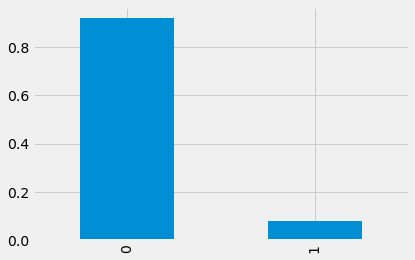

In [31]:
# Find out the % of churn/non churn customers
churn_percentage = telecom_df_high_val_cust.churn.value_counts(normalize=True)
print(churn_percentage)
churn_percentage.plot.bar()
plt.show()

**Observation** : The churn percentage is around 8%. This indicates that there is a slight imbalance in the dataset which will need to be corrected in modelling

**Drop all data of the ninth Month as that is our Target Variable**


In [32]:
churn_month_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

In [33]:
churn_month_columns

Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'date_of_last_rech_9', 'last_day_rch_amt_9', 'total_rech_data_9',
       'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9',
       'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9',
       'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9',
       'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9'],

In [34]:
# drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

In [35]:
telecom_df_high_val_cust.shape

(29953, 160)

### Step 4 : EDA ### 

We will now perform EDA and try to get insights into the data. 
Based on the insights we could define our approach to training, remove outliers, remove highly correlated variables

In [36]:
#CheckPoint 1 
telecom_eda_df = telecom_df_high_val_cust.copy()


#### 4.1 Bi variate Analysis of Various Variables with the Churn Variable ####
We will draw trends of the selected categorical variables data wrt to the Label, Churn and see if we can derive any meaningful insights

**Utility Functions**

In [37]:
# create box plot for  6th, 7th and 8th month
def create_box_plot(column):
    plt.figure(figsize=(15,10))
    df = telecom_eda_df
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=column+"_6",x="churn", showfliers=False)
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=column+"_7",x="churn", showfliers=False)
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=column+"_8",x="churn", showfliers=False)
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
    


In [38]:
# create box plot for  6th, 7th and 8th month
def create_bar_plot(column):
    plt.figure(figsize=(15,10))
    df = telecom_eda_df
    plt.subplot(2,3,1)
    sns.barplot(data=df, y=column+"_6",x="churn")
    plt.subplot(2,3,2)
    sns.barplot(data=df, y=column+"_7",x="churn")
    plt.subplot(2,3,3)
    sns.barplot(data=df, y=column+"_8",x="churn")
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [39]:
def showbarlabel(graph, rotate=0):
    graph.set_xticklabels(graph.get_xticklabels(),rotation=rotate)
    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

In [40]:
def plot_bar(by,rotate=0):
    df = telecom_df_high_val_cust
    graph = df[by].value_counts(sort=True).plot(kind='bar')
    showbarlabel(graph,rotate)

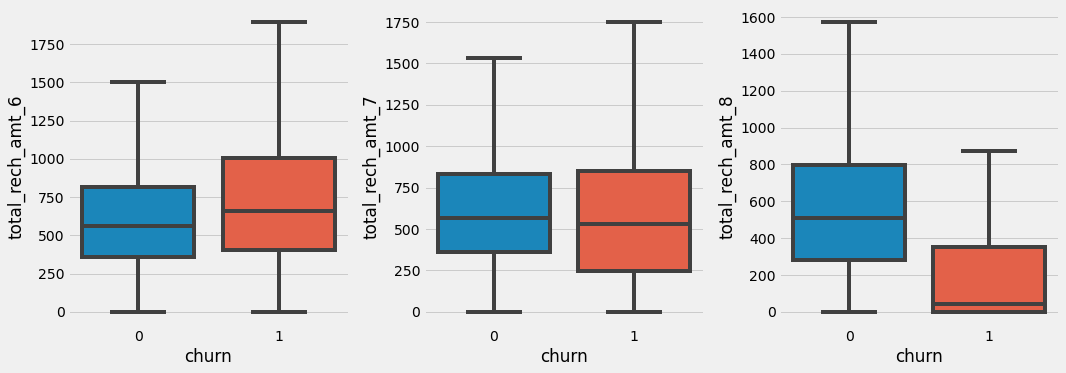

In [41]:
# Ploting for Total recharge amount :
create_box_plot('total_rech_amt')

**Observation** : Total Recharge amount drops in month 8 indicating Churn 

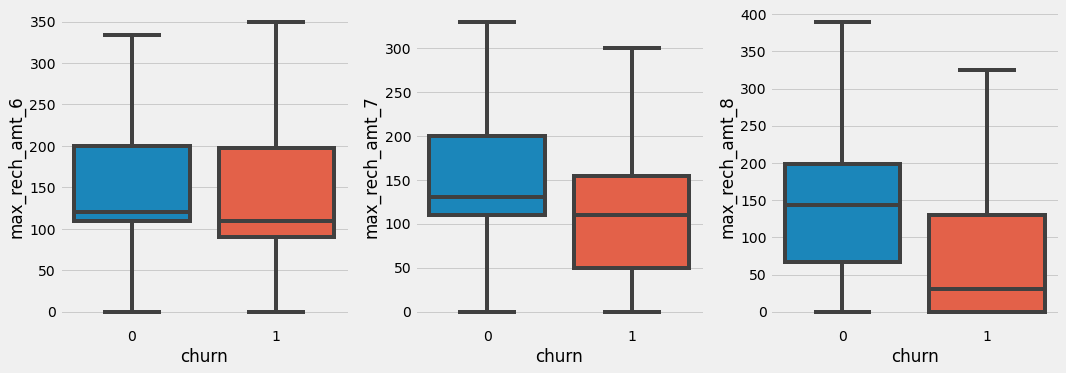

In [42]:
# Ploting for maximum recharge amount :
create_box_plot('max_rech_amt')

**Observation**  : We can see that there is a huge drop in maximum recharge amount for churned customers in the 8th month i.e action phase


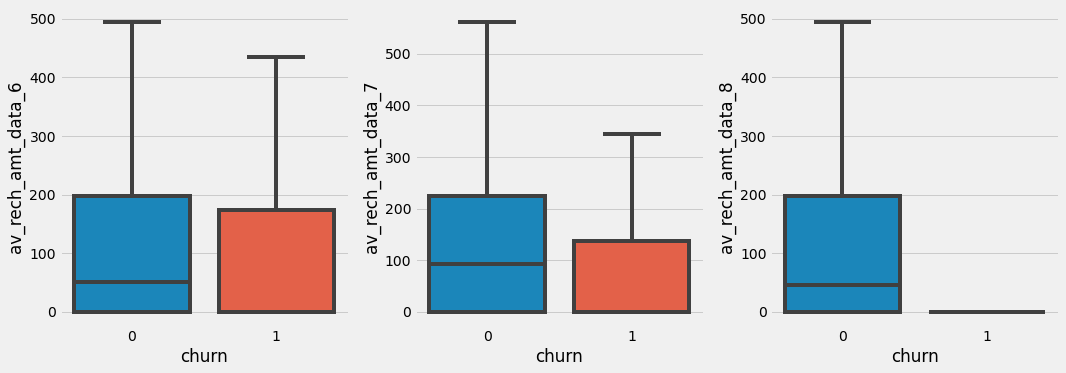

In [43]:
create_box_plot('av_rech_amt_data')

**Observation** : Average Recharge amount drops in month 8 indicating Churn 

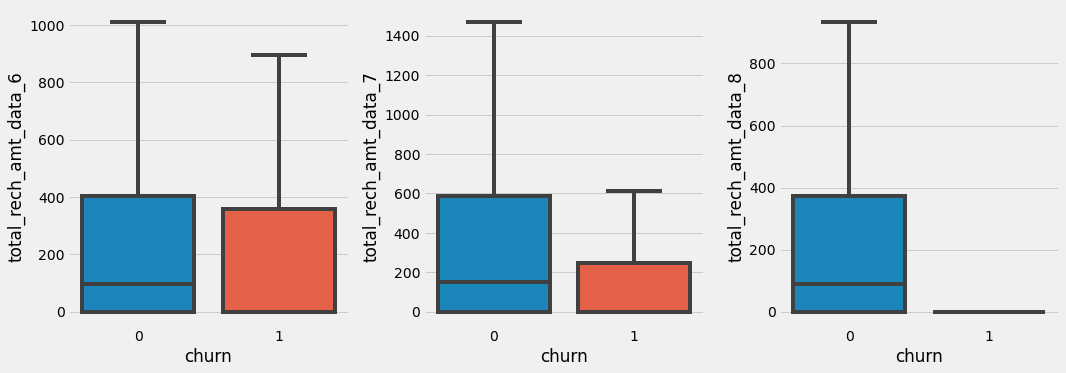

In [44]:
# Ploting for total recharge amount data :
create_box_plot('total_rech_amt_data')


**Observation** : We can see a drop in the total recharge for data for churned customers in the 8th Month i.e Action Phase

In [45]:
# all Recharge Number related column list
recharge_num_columns = [col for col in telecom_df_high_val_cust if 'rech_num' in col.lower()]
recharge_num_columns

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8']

In [46]:
100*telecom_df_high_val_cust[recharge_num_columns].isnull().sum()/len(telecom_df_high_val_cust.index)
# We don't have any missing values here

total_rech_num_6   0.00
total_rech_num_7   0.00
total_rech_num_8   0.00
dtype: float64

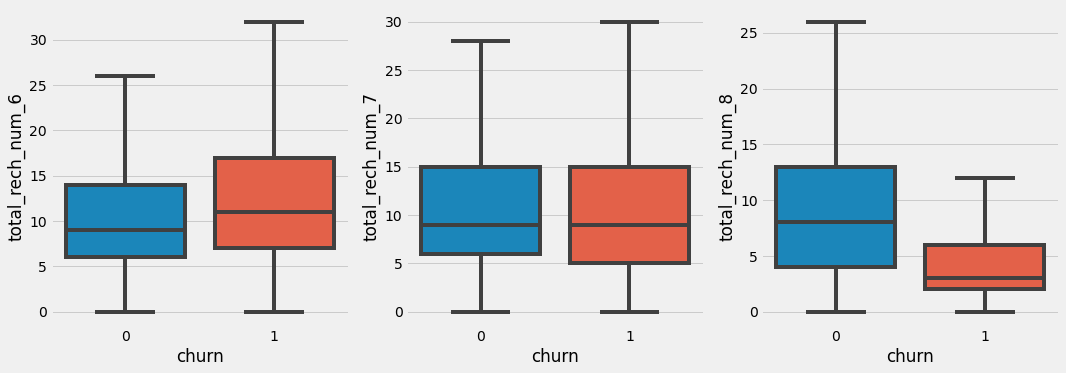

In [47]:
# Ploting for total recharge number:
create_box_plot('total_rech_num')

**Observation** : We can see that there is a huge drop in total recharge number for churned customers in the 8th month i.e action phase

In [48]:
# all Recharge data related column list
recharge_data_columns = [col for col in telecom_df_high_val_cust if 'rech_data' in col.lower()]
recharge_data_columns

['total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8']

In [49]:
100*telecom_df_high_val_cust[recharge_data_columns].isnull().sum()/len(telecom_df_high_val_cust.index)
# We don't have any missing values here

total_rech_data_6   0.00
total_rech_data_7   0.00
total_rech_data_8   0.00
max_rech_data_6     0.00
max_rech_data_7     0.00
max_rech_data_8     0.00
dtype: float64

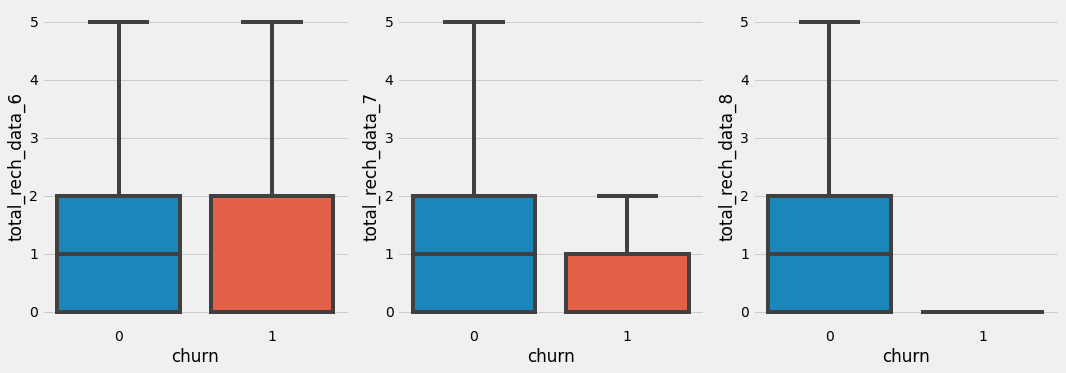

In [50]:
# Ploting for total recharge data:
create_box_plot('total_rech_data')

**Observation** : Again we can see that there is a huge drop in total recharge amount data for churned customers in the 8th month i.e action phase

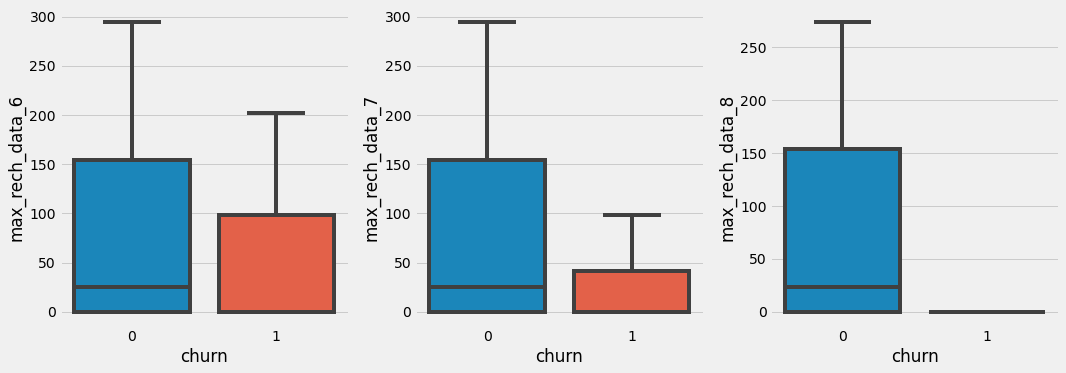

In [51]:
# Ploting for max recharge for data:
create_box_plot('max_rech_data')

**Observation** : There is a huge drop in max recharge amount data for churned customers in the 8th month i.e action phase 

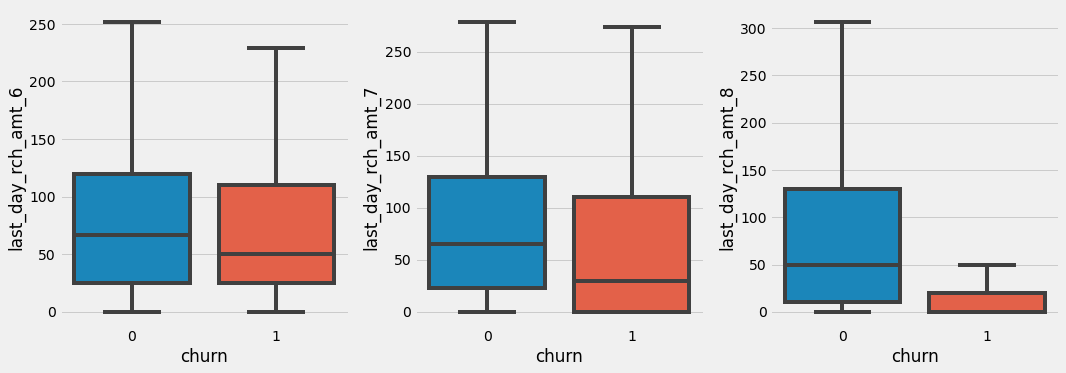

In [52]:
# Ploting for Last  day recharge amount  :
create_box_plot('last_day_rch_amt')

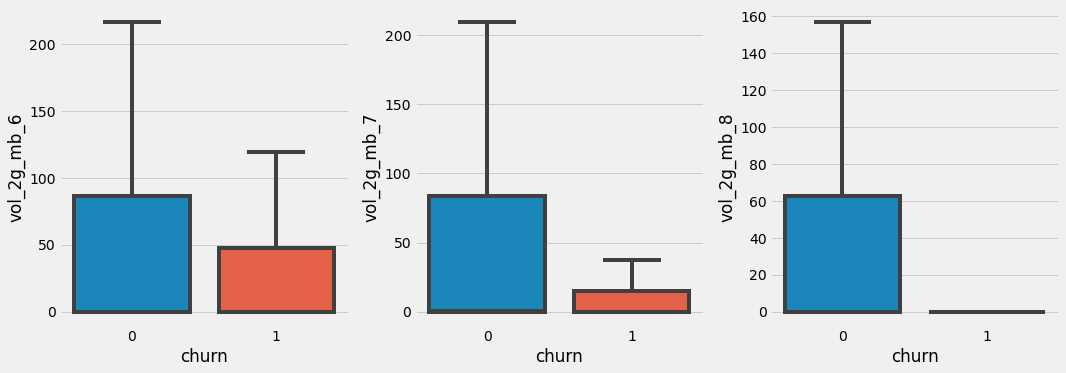

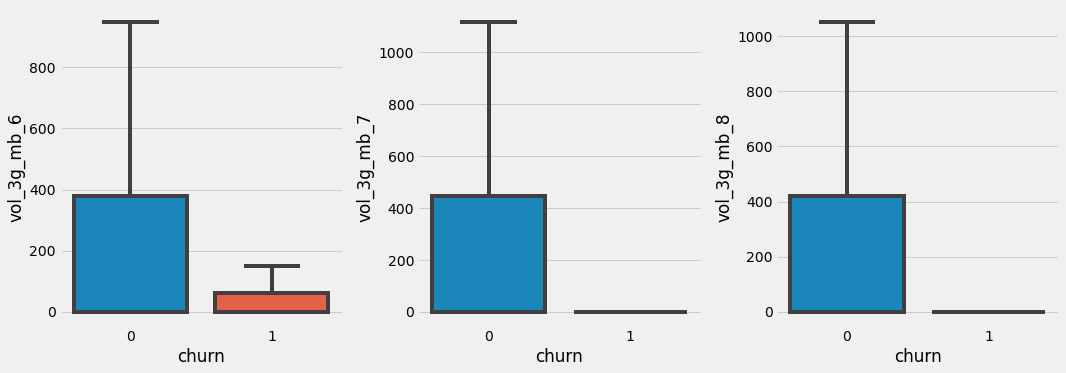

In [53]:
# Ploting for volume of 2G and 3G usage columns:
create_box_plot('vol_2g_mb')
create_box_plot('vol_3g_mb')

**Observation** 
We see 2g and 3g usage for churned customers drops in the 8th month i.e Action phase.

However in general we see the usage is low for churned customer across months. 

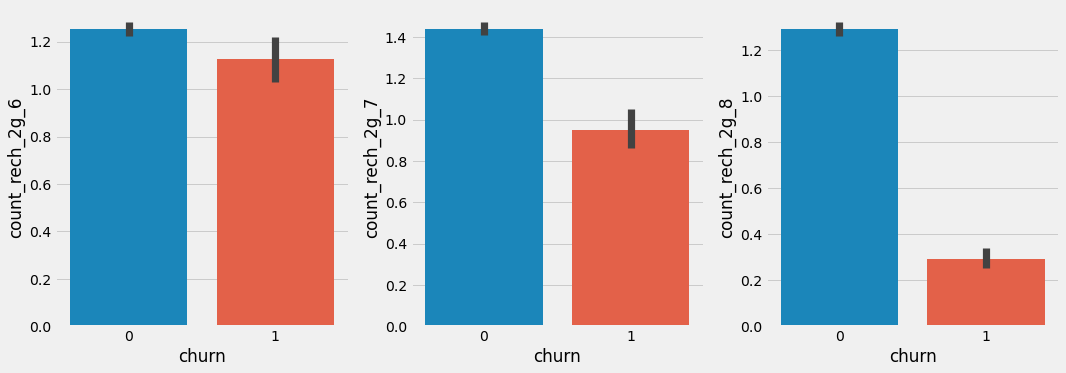

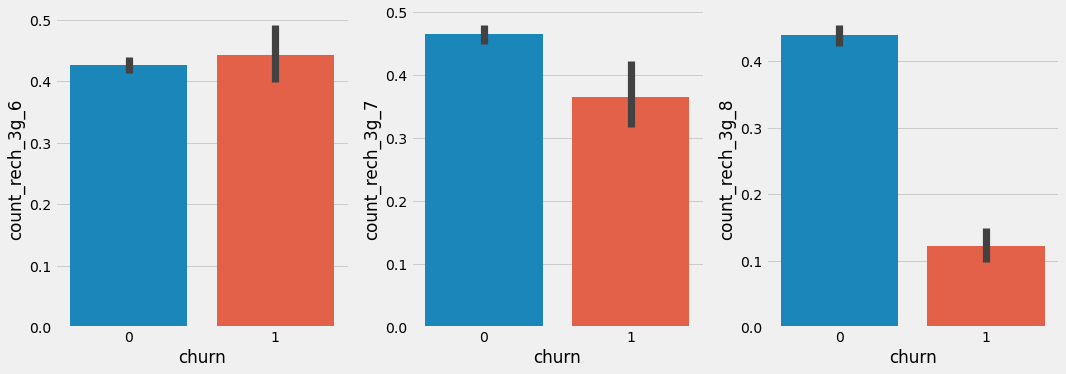

In [54]:
# Ploting for count of 2G and 3G recharge columns:
create_bar_plot('count_rech_2g')
create_bar_plot('count_rech_3g')

**Observation** 
We see 2g and 3g recharge counts for churned customers drops in the 8th month i.e Action phase.



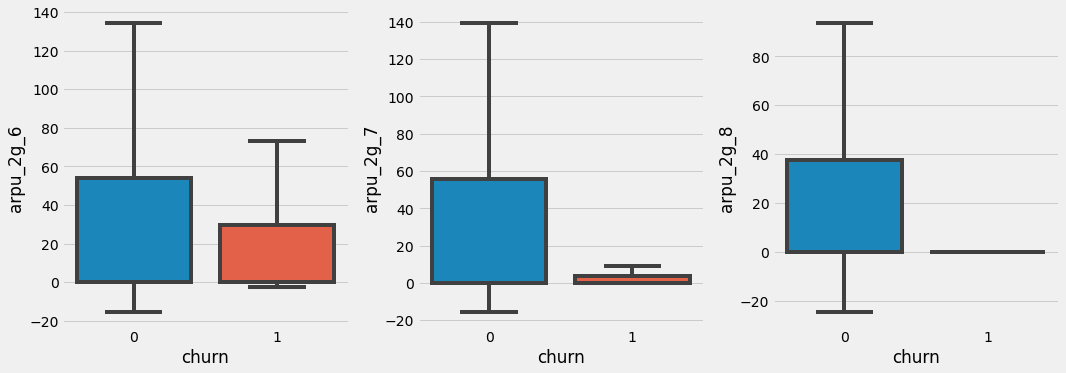

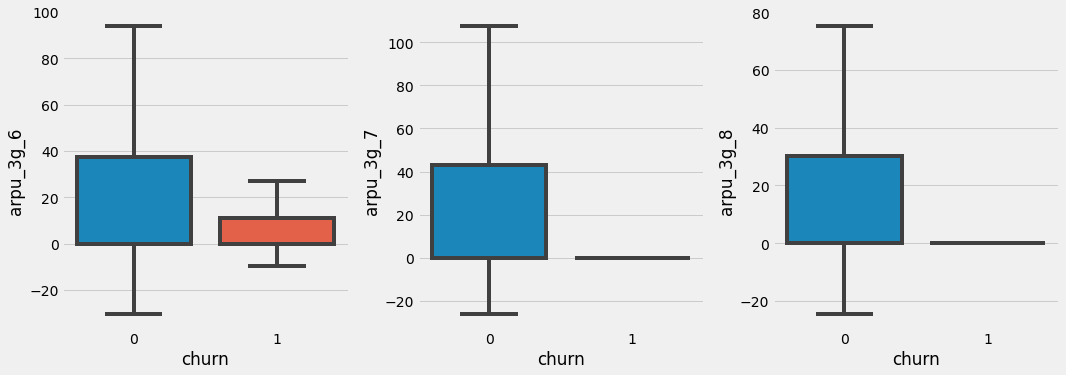

In [55]:
# Ploting for arpu of 2G and 3G usage columns:
create_box_plot('arpu_2g')
create_box_plot('arpu_3g')

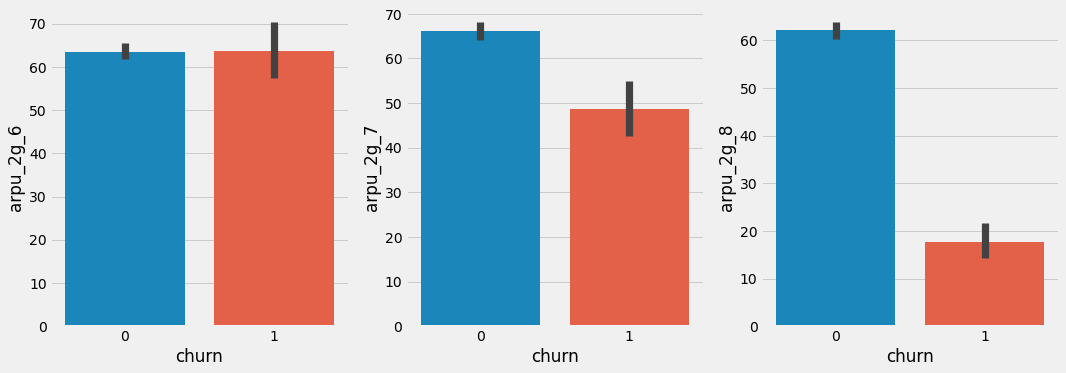

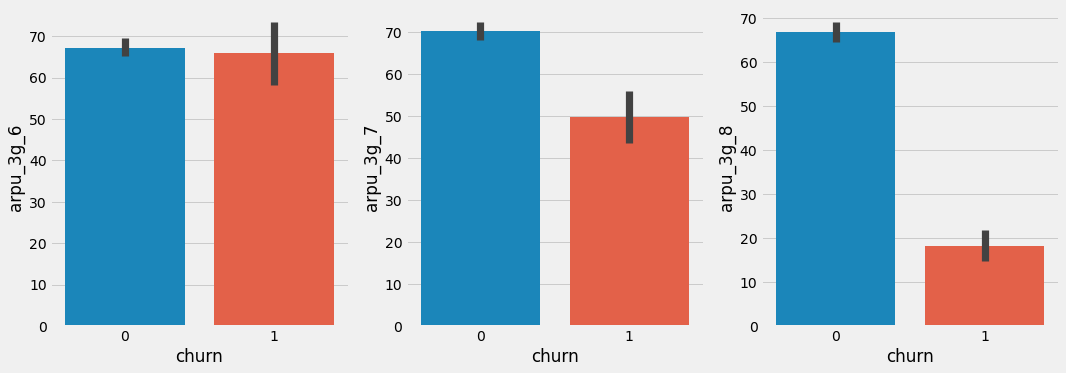

In [56]:
# Ploting bar plot for arpu of 2G and 3G usage columns:
create_bar_plot('arpu_2g')
create_bar_plot('arpu_3g')

**Observation** 
We see 2g and 3g arpu for churned customers drops in the 8th month i.e Action phase.



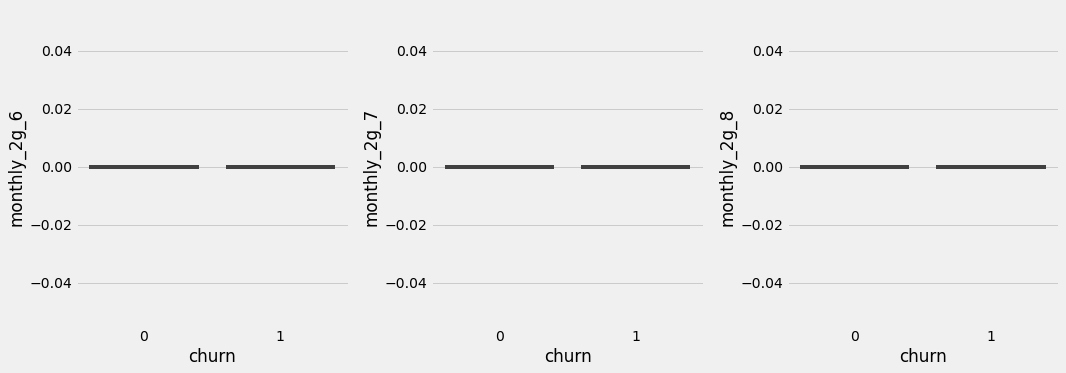

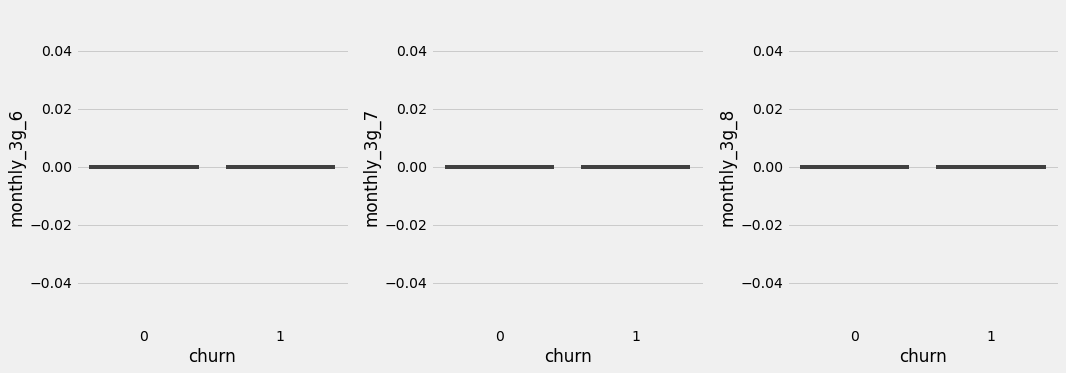

In [57]:
# Ploting for monthly subcription of 2G and 3G usage columns:
create_box_plot('monthly_2g')
create_box_plot('monthly_3g')

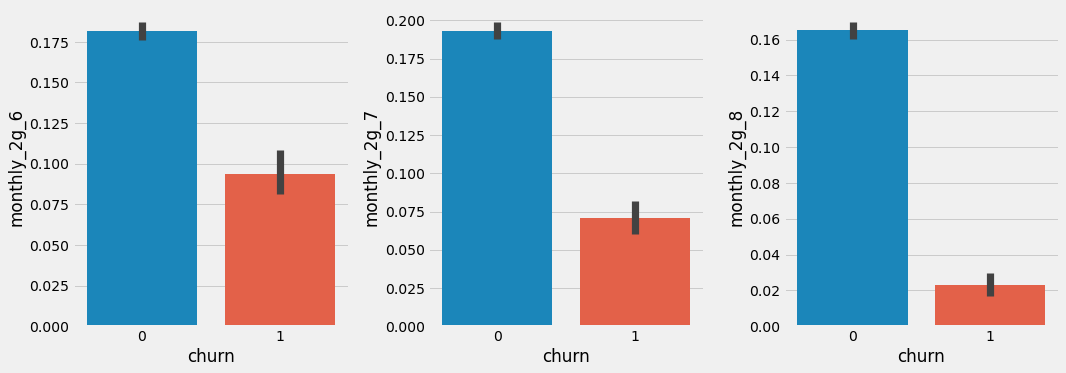

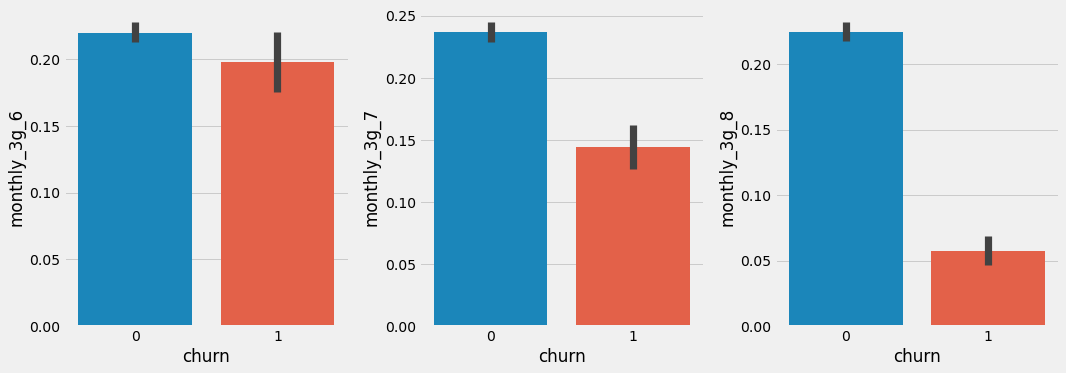

In [58]:
# Plotting a bar plot as box plot doesn't show any pattern
create_bar_plot('monthly_2g')
create_bar_plot('monthly_3g')

**Observation** 
We see 2g and 3g monthly subscription for churned customers drops in the 8th month i.e Action phase.



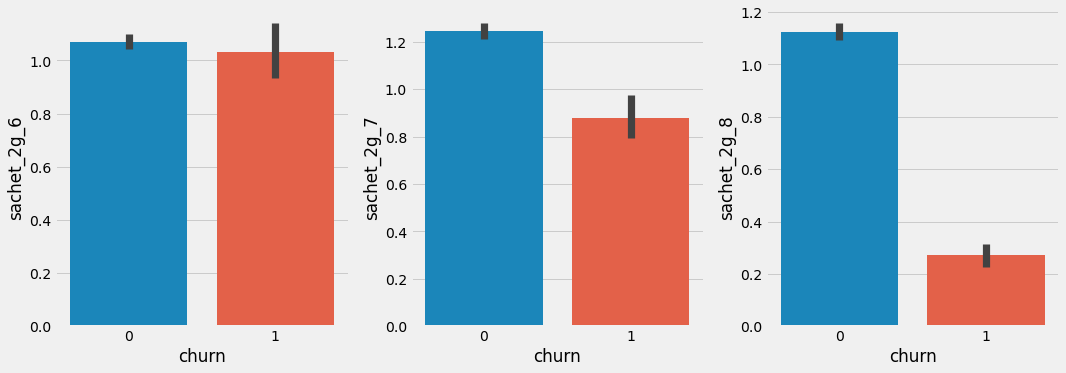

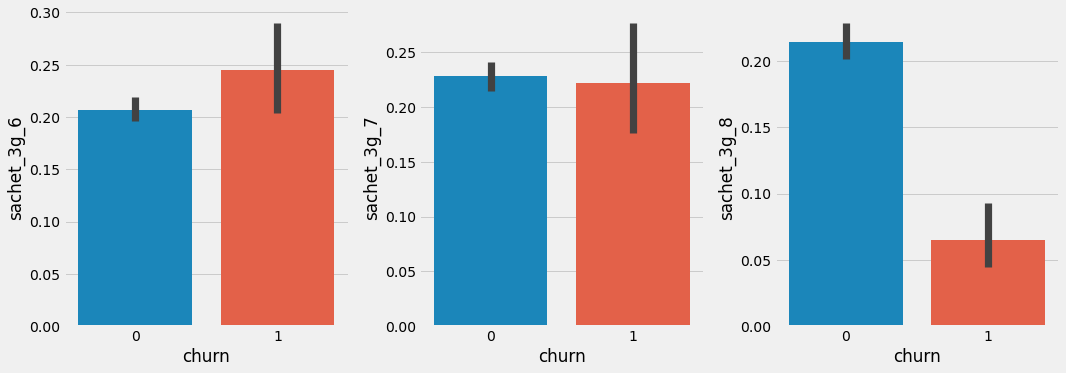

In [59]:
# Plotting for small duration subscription of 2g and 3g data
# Plotting a bar plot as box plot doesn't show any pattern
create_bar_plot('sachet_2g')
create_bar_plot('sachet_3g')

**Observation** 
We see 2g and 3g small duration subscription for churned customers drops in the 8th month i.e Action phase.





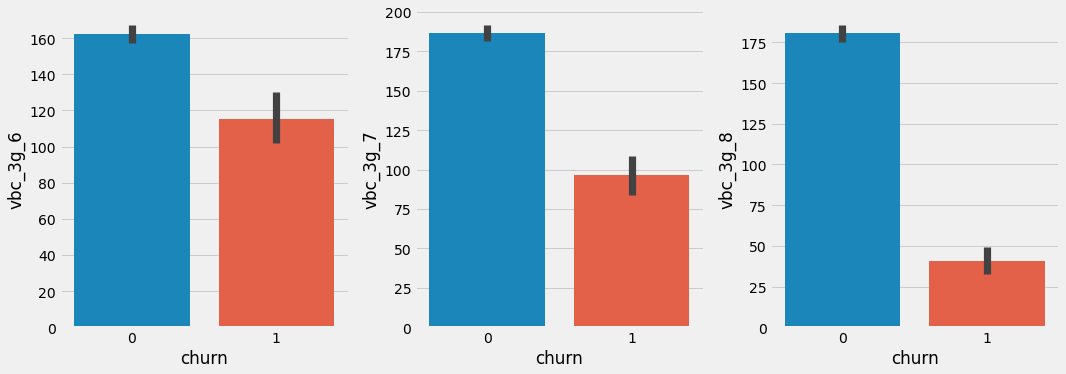

In [60]:
#Plotting volume based 3g usage
create_bar_plot('vbc_3g')

In [61]:
#Getting the  day  columns
day_columns = [col for col in telecom_df_high_val_cust if 'day' in col.lower()]
day_columns

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

In [62]:
100*telecom_df_high_val_cust[day_columns].isnull().sum()/len(telecom_df_high_val_cust.index)
# We don't have any missing values here

last_day_rch_amt_6   0.00
last_day_rch_amt_7   0.00
last_day_rch_amt_8   0.00
dtype: float64

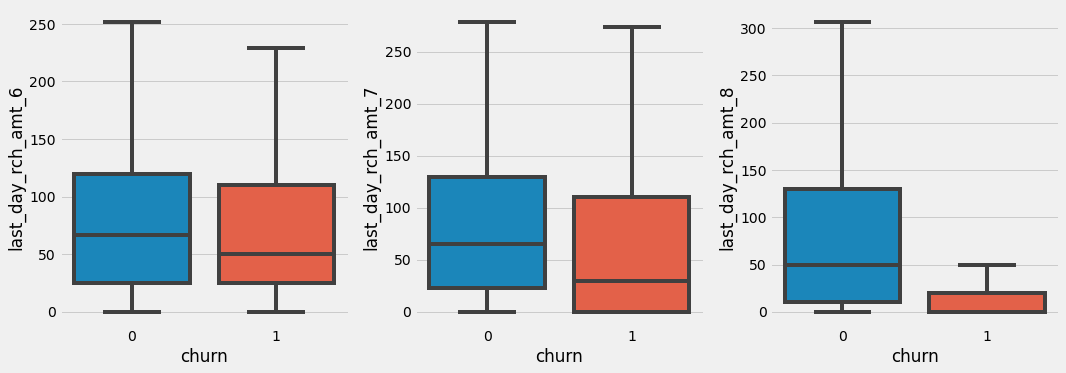

In [63]:
create_box_plot('last_day_rch_amt')

Huge drop in 8th month for last day recharge amount indicating  churn

In [64]:
# all Date column list
date_columns = [col for col in telecom_df_high_val_cust if 'date' in col.lower()]
date_columns

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [65]:
100*telecom_df_high_val_cust[date_columns].isnull().sum()/len(telecom_df_high_val_cust.index)


date_of_last_rech_6   0.24
date_of_last_rech_7   0.33
date_of_last_rech_8   1.94
dtype: float64

The missing value indicates that recharge date and the recharge value are missing together which means the customer didn't recharge for that month

In [66]:
telecom_df_high_val_cust[telecom_df_high_val_cust.date_of_last_rech_6.isnull()][['total_rech_data_6','date_of_last_rech_6']].head()

,total_rech_data_6,date_of_last_rech_6
91,0.00,NaT
414,0.00,NaT
6319,0.00,NaT
8125,0.00,NaT
8975,0.00,NaT


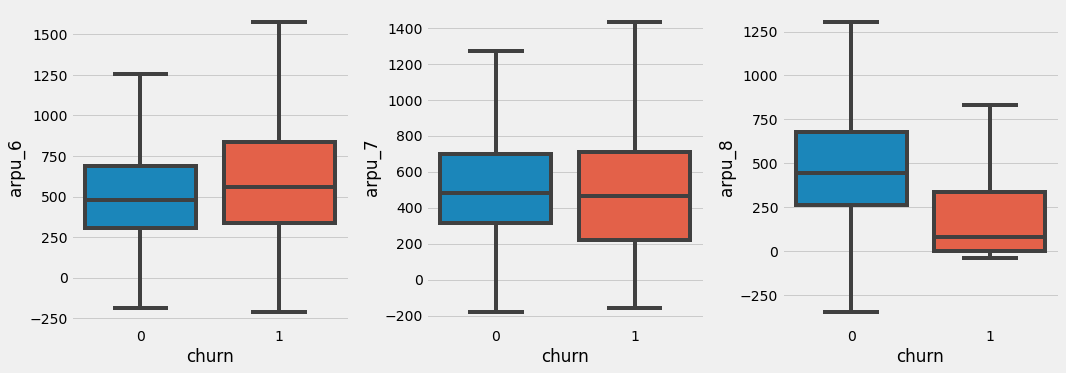

In [67]:
#Plot for ARPU 
create_box_plot('arpu')

**Observation** 
We see the ARPU for churned customers drops in the 8th month i.e Action phase.



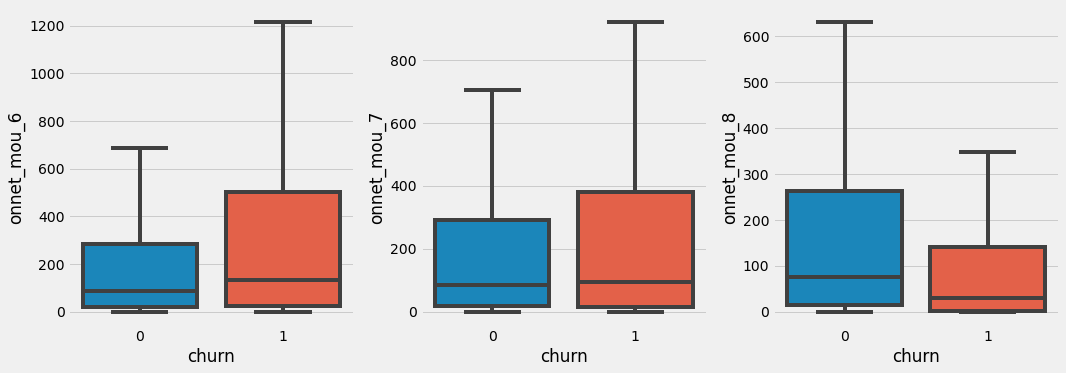

In [68]:
#Plot for Onnet Minutes of Usage
create_box_plot('onnet_mou')

The calls on service provider network drops in month 8 indicates Churn

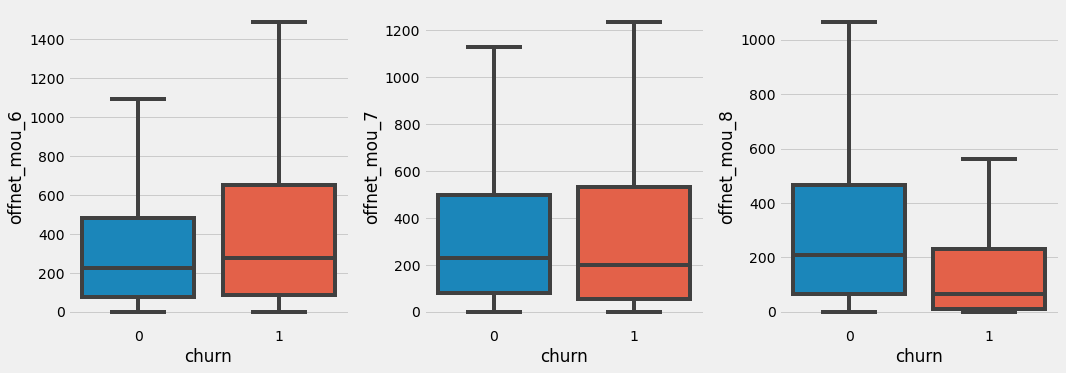

In [69]:
#Plot for Offnet Minutes of Usage
create_box_plot('offnet_mou')

The calls to different network drops in month 8 indicates Churn

#### General Observation from above EDA #### 
- We see churned customers drops in the 8th month i.e Action phase.
- We can also see that the trend reversal happens drastically in the 9th month. 
- In the 6th and 7th month, the variance captured between the Churned and Non Churned customers is not much.
- So to reduce dimensionality it might be a good idea to average out the values of both the columns and drop the individual months. 
- We can test this hypothesis in the models later


#### 4.2 Dimensionality Reduction  ####

Based  on the EDA done above, we will reduce the dimensionality to make forecasting of the trends easier based on the  features



**Dimensionality Reduction | Drop Highly Correlated Columns as a PreRequisite to EDA**

In [70]:
## Creating a copy to avoid regenerating master for each iterations
##Check point 2
training_df = telecom_eda_df.copy()

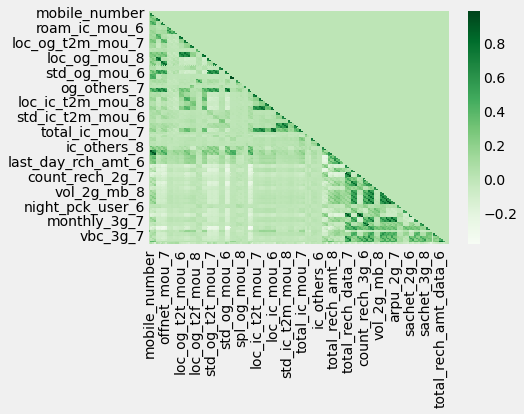

In [71]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = training_df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
sns.heatmap(cor, cmap='Greens', annot=False, )
plt.show()

Looks like there are strong multicollinearity issues, Lets drop data which is multi collinear

In [72]:
# Create correlation matrix
corr_matrix = training_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [73]:
## Filter columns of months where only all months are highly correlated, others we will ignore 
to_drop_filtered = ['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 #'std_og_t2m_mou_7',
 #'std_og_t2m_mou_8',
# 'isd_og_mou_7',
# 'isd_og_mou_8',
 #'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
# 'monthly_3g_7',
#'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
]

training_df.drop(to_drop_filtered, axis =1, inplace=True)


**Dimensionality Reduction | Drop the Date Columns as they are already factored in the other columns, Drop Mobile Number as its not meaningful to prediction**

In [74]:
training_df.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','mobile_number'], axis=1, inplace=True)

In [75]:
training_df.shape

(29953, 135)

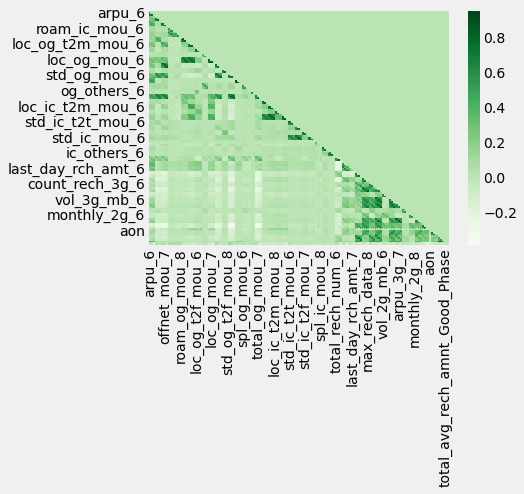

In [76]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = training_df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
sns.heatmap(cor, cmap='Greens', annot=False)
plt.show()

In [77]:
#Checkpoint 3
# We can run from checkpoints rather than run the entire notebook for validation
telecom_df_high_val_cust = training_df.copy()

**Dimensionality Reduction | Avg Out the 6th and 7th Month to reduce the number of Features**

In [78]:
# Creating Avg Column 

col_list = telecom_df_high_val_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_df_high_val_cust.shape)

for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_high_val_cust[avg_col_name] = (telecom_df_high_val_cust[col_6]  + telecom_df_high_val_cust[col_7])/ 2

(29953, 135)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2m_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
loc_ic_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
count_rech_3g
av_rech_amt_data
vol_2g_mb
vol_3g_mb
arpu_3g
night_pck_user
monthly_2g
monthly_3g
fb_user
vbc_3g
total_rech_amt_data


In [79]:
#Drop the individual columns

print (telecom_df_high_val_cust.shape)

col_list = telecom_df_high_val_cust.filter(regex='_6|_7').columns

telecom_df_high_val_cust.drop(col_list, axis=1, inplace=True)
telecom_df_high_val_cust.shape

(29953, 179)


(29953, 91)

#### Univariate Analysis 

**Analyse sample of  categorical variables and see if we can draw any meaningful insights**

In [80]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    counter = 0;
    for i in range(min(nCol,nGraphShown)):
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), pd._libs.tslibs.timestamps.Timestamp)):
            plt.subplot(nGraphRow, nGraphPerRow, counter+1)
            #increment the counter
            counter +=1
            if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
                valueCounts = columnDf.value_counts()
                valueCounts.plot.bar()
            else:
                columnDf.hist()
                plt.ylabel('counts')
                plt.xticks(rotation = 90)
                plt.title(f'{columnNames[i]} (column {i})')
        
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

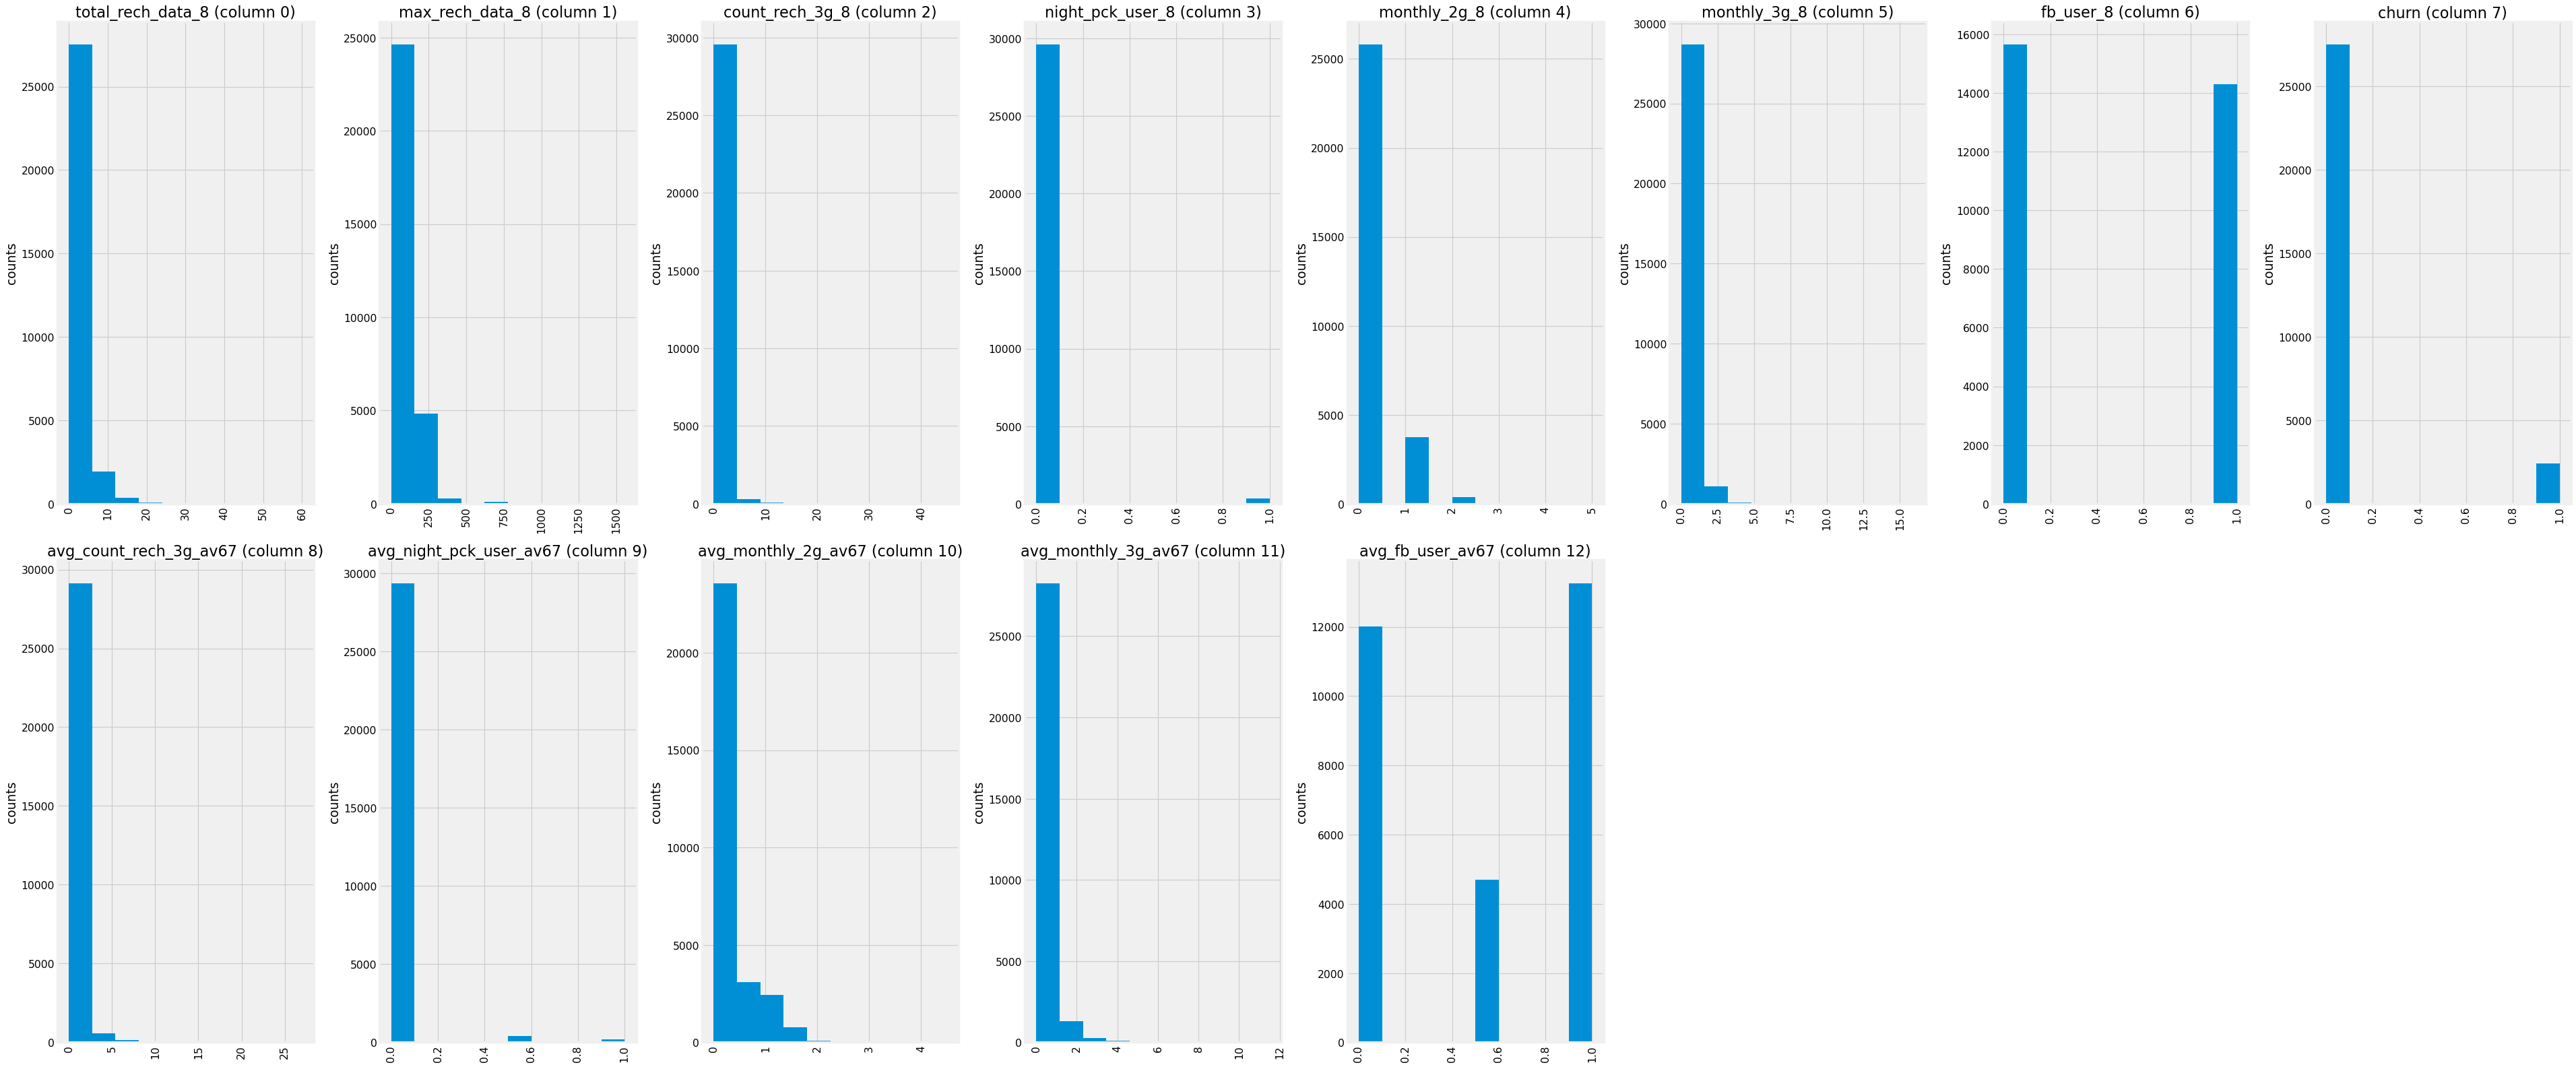

In [81]:
plotPerColumnDistribution(telecom_df_high_val_cust,30,8)

**Observation** -
* Histogram distribution shows twin peaks(bimodal) or single peaks on the lower bars of the distribution.
* The distribution is not normal, which indicates this could be a higher order linear or non linear distribution. 
* Smoothening may be required for better prediction. 
* The distribution is sparse or spread in one bucket

**Analysis of sample of  Numeric/Continuous Features to see if we can derive any trends**

In [82]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

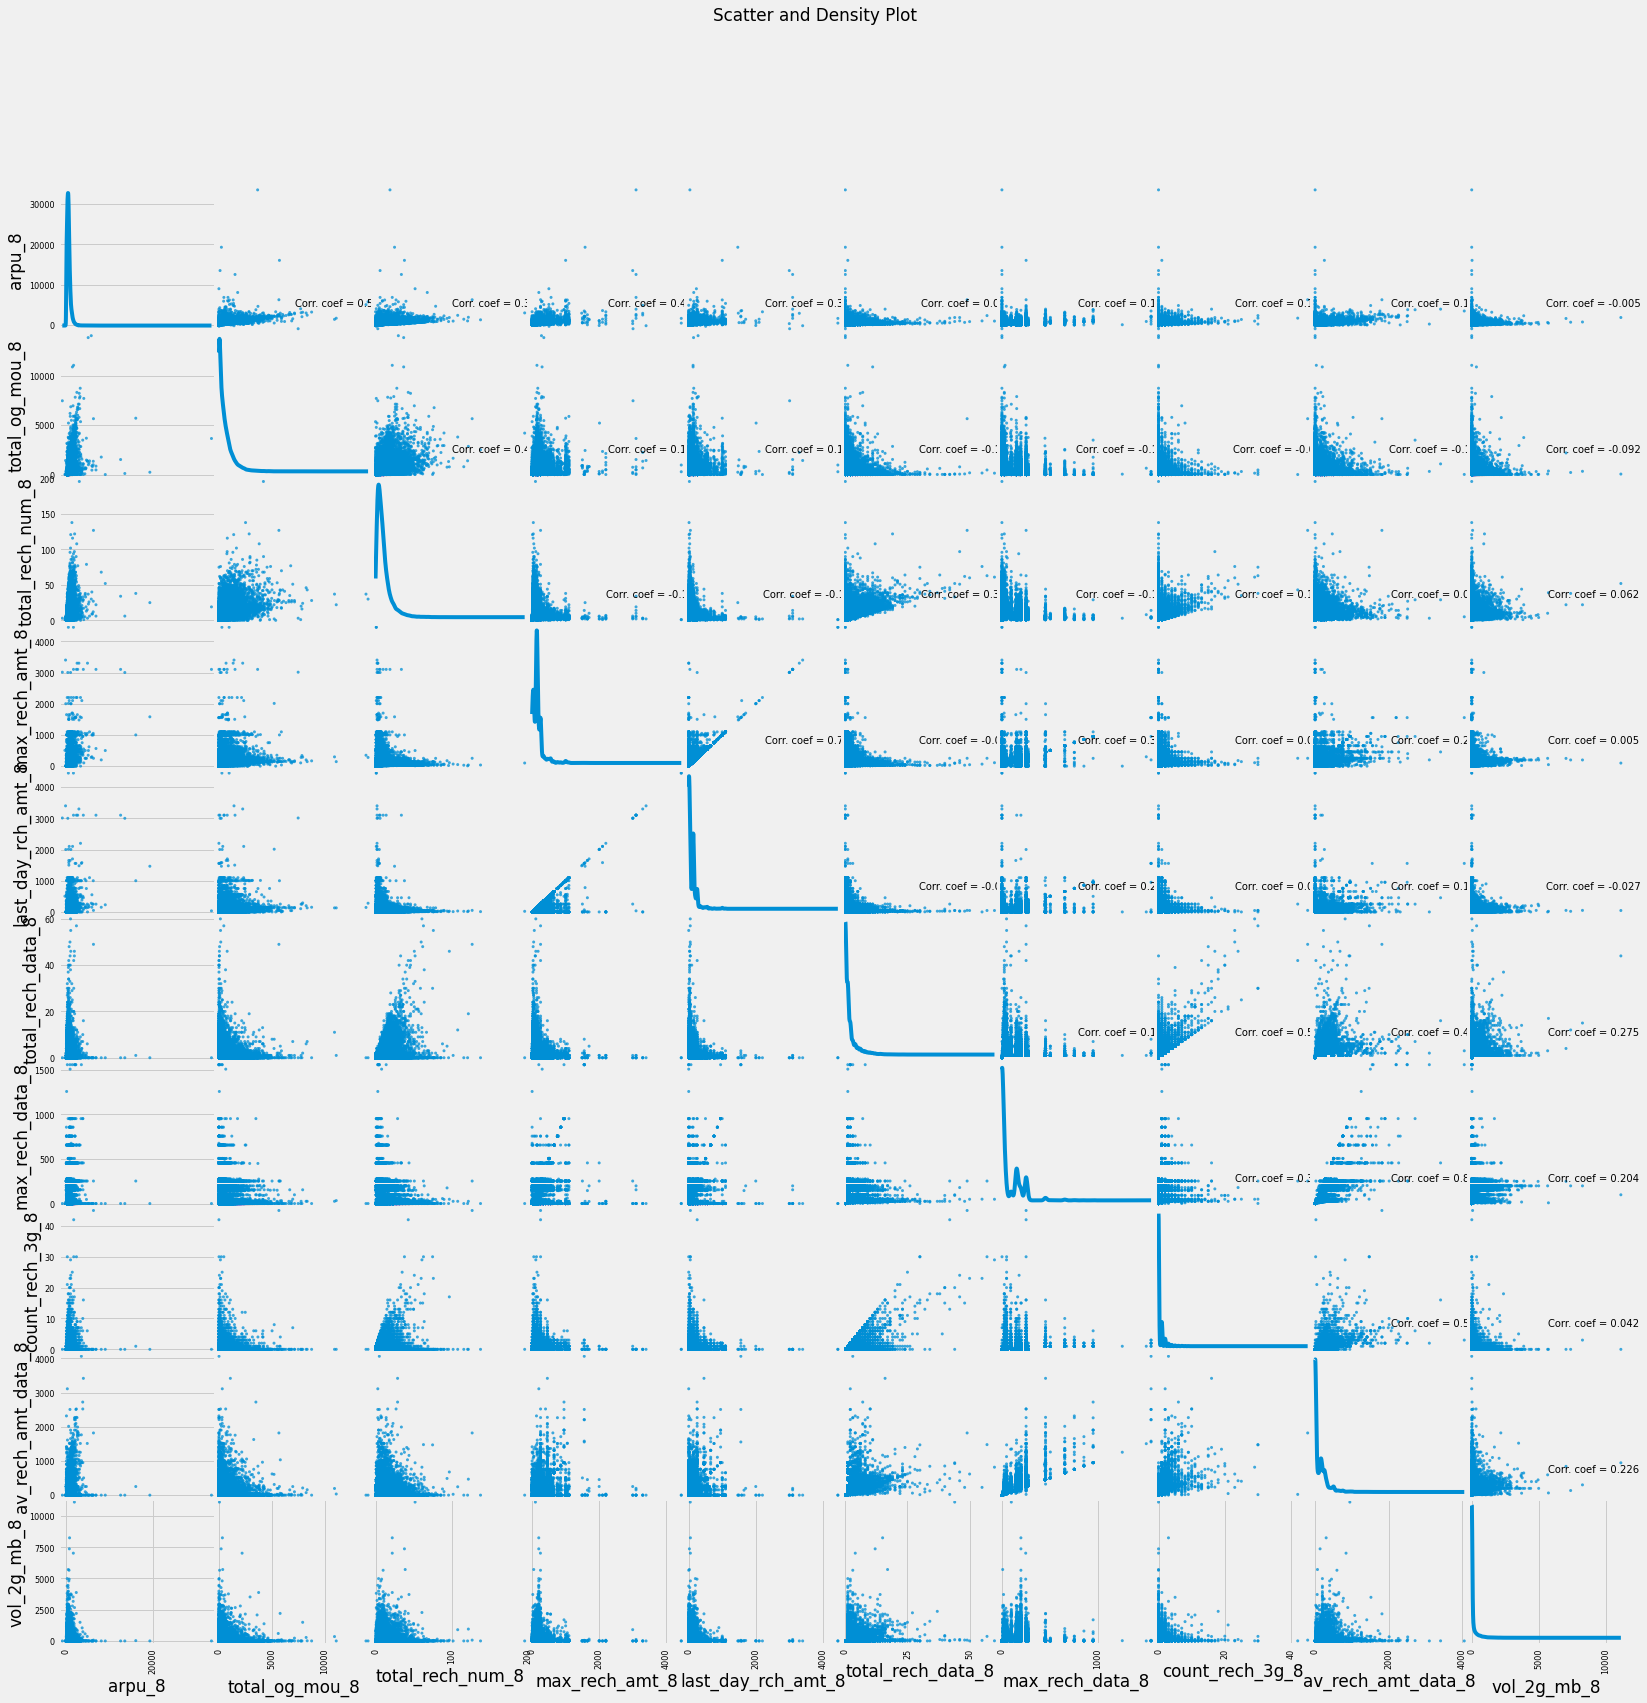

In [83]:
plotScatterMatrix(telecom_df_high_val_cust, 25, 10)

**Observation** :
* Relation between the variables are not obviously linear
* All numeric variables are having distributions which are not normal


**Analysis of Tenure with Churn**

In [84]:
#Convert AON in Months
telecom_df_high_val_cust['aon_mon'] = telecom_df_high_val_cust['aon']/30
telecom_df_high_val_cust.drop('aon', axis=1, inplace=True)
telecom_df_high_val_cust['aon_mon'].head()

0    32.27
7    26.73
8    10.50
21   24.00
23   20.13
Name: aon_mon, dtype: float64

In [85]:
telecom_df_high_val_cust.aon_mon.describe()

count   29953.00
mean       40.31
std        31.91
min         6.00
25%        15.33
50%        28.20
75%        58.53
max       144.03
Name: aon_mon, dtype: float64

Text(0.5, 1.0, 'Customers by their tenure')

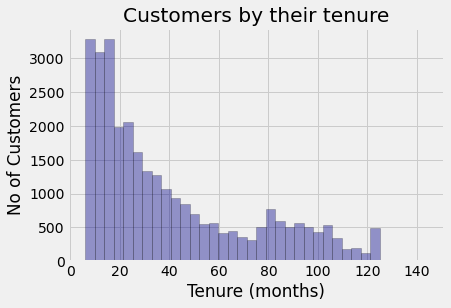

In [86]:
ax = sns.distplot(telecom_df_high_val_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Customers by their tenure')

In [87]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_df_high_val_cust['tenure_range'] = pd.cut(telecom_df_high_val_cust['aon_mon'], tn_range, labels=tn_label)
telecom_df_high_val_cust['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

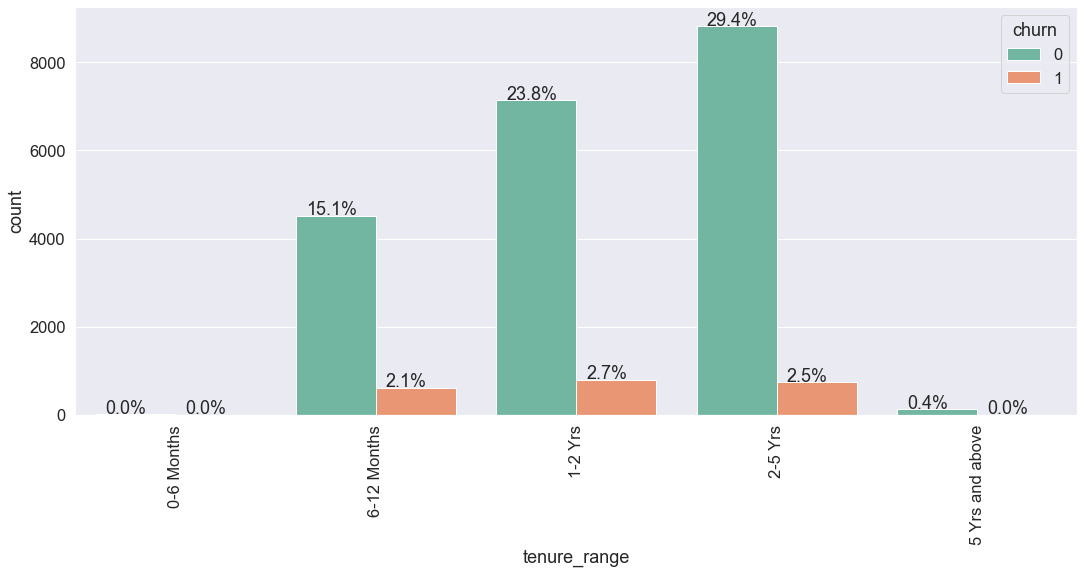

In [88]:
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

temp = pd.Series(data = 'tenure_range')
fig, ax = plt.subplots()
width = len(telecom_df_high_val_cust['tenure_range'].unique()) + 6 + 4*len(temp.unique())
fig.set_size_inches(width , 7)

total = float(len(telecom_df_high_val_cust.index))
ax = sns.countplot(x="tenure_range", data=telecom_df_high_val_cust, palette="Set2", hue = "churn");
for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(telecom_df_high_val_cust))), (p.get_x()+0.05, p.get_height()+20))
plt.xticks(rotation=90)
plt.show()


**Correlation of  Churn with all Variables**

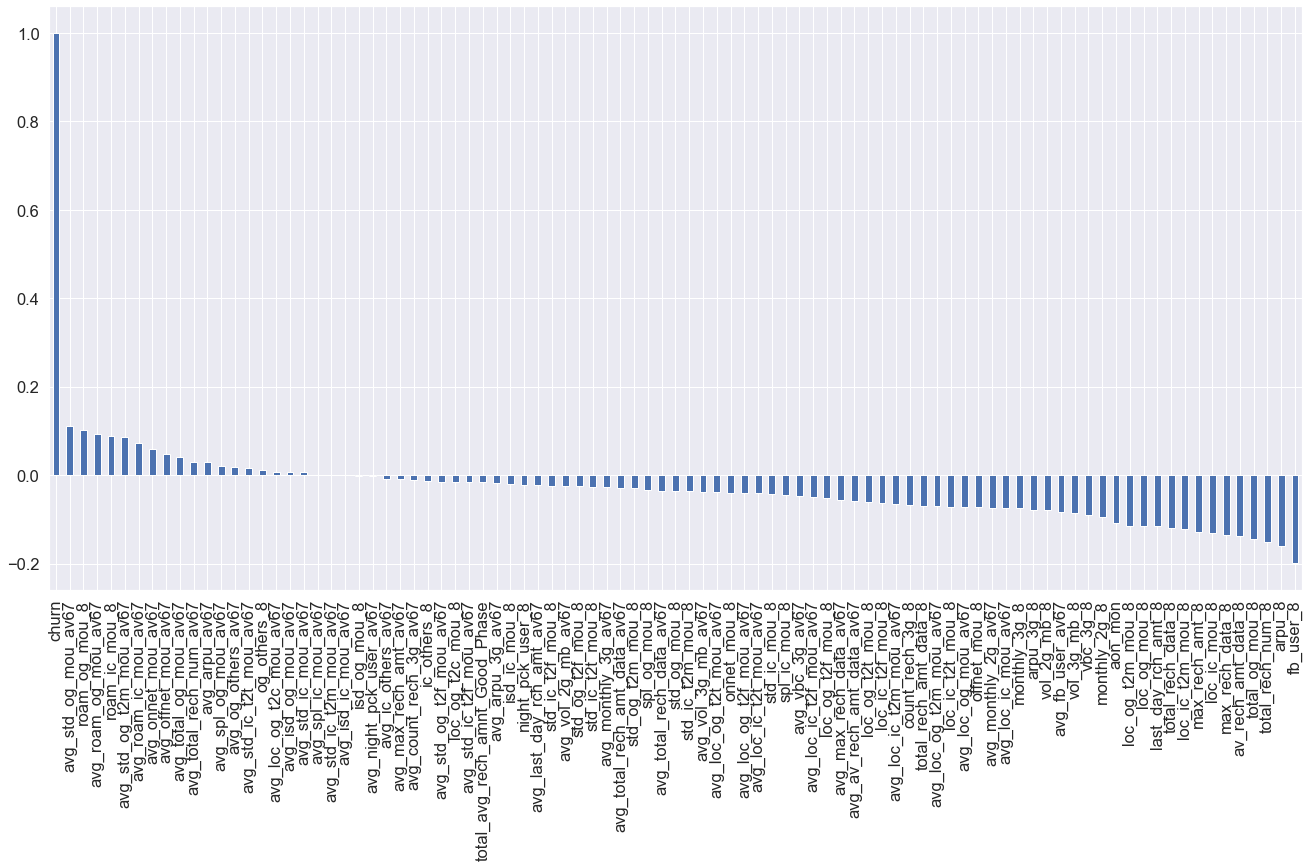

In [89]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(20,10))
telecom_df_high_val_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')
plt.show()

**Observation**

*Positive Corelation with*
- Churn has got maximum correlation with "Avg Std Outgoing Month 6 and 7"
- Roaming Outgoing/Incoming Minutes

*Negative Corelation with*
- fb Usage Plan for 8th Month
- arpu 8th Month
- Total Outgoing 8th Month

Lets also validate if ARPU8 and TotalRech8 are correlated, and if so we should eliminate one of these variables

**Relation between ARPU8 and TotalRecharge Num in 8th Month**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


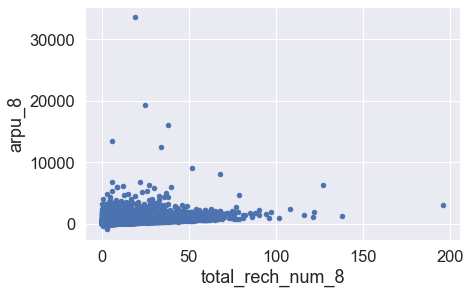

In [90]:
telecom_df_high_val_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')
plt.show()

**Observation** : Looks like they are not correlated and we will keep both the variables

## Step 3: Model Building

Moving towards Model Building
Also drop a **Mobile Number** and **Tenure**


### 3.1 Pre Training Steps ###

In [91]:
## Checkpoint 5

model_df = telecom_df_high_val_cust[:].copy()
telecom_df_high_val_cust.shape


(29953, 92)

In [92]:
#Dropping tenure_range since we have AON MONTH already and columns are highly coorelated
model_df.drop('tenure_range', axis=1, inplace=True)

#dropping total_avg_rech_amnt_Good_Phase which was calculated to find High Value customers.

model_df.drop('total_avg_rech_amnt_Good_Phase', axis=1, inplace=True)

#Since All The Values are realted to Price/ Cost/ Amount, Filling NaN with 0

model_df.fillna(0, inplace=True)

model_df.head()


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,night_pck_user_8,monthly_2g_8,monthly_3g_8,fb_user_8,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_std_og_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_total_og_mou_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_loc_ic_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_std_ic_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_count_rech_3g_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_arpu_3g_av67,avg_night_pck_user_av67,avg_monthly_2g_av67,avg_monthly_3g_av67,avg_fb_user_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67,aon_mon
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,1.00,252.00,1.00,252.00,5.75,109.61,212.17,0.00,0,1,1.00,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,252.00,252.00,1.00,252.00,1.00,252.00,15.72,117.16,212.17,0.00,0.00,1.00,1.00,50.60,252.00,32.27
7,3171.48,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,49.14,16.68,77.84,10.01,6.50,0.00,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,0.00,31.59,15.14,7,1580,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,57.74,0.00,1,1209.51,56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,478.03,40.83,13.37,68.00,0.09,2.25,0.00,548.38,45.20,219.53,126.81,391.56,24.36,109.22,43.22,176.81,0.10,8.29,15.46,5.00,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00,26.73
8,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,75.69,0.00,98.28,0.00,10.23,0.00,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,0.00,0.00,0.00,14,30,10,3.00,23.00,0.00,69.00,0.03,11.94,19.83,0.00,0,0,1.00,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,333.13,11.86,0.00,136.87,0.00,0.00,0.00,470.01,16.84,35.78,0.00,52.63,0.29,13.25,0.00,13.54,0.00,0.00,0.00,20.00,122.00,25.00,1.00,77.00,0.00,88.50,178.00,375.48,0.00,0.00,0.50,0.00,0.50,516.40,177.00,10.50
21,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,876.99,0.00,938.79,0.00,0.00,0.00,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,0.00,0.00,0.00,27,50,50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,95.56,737.05,0.00,848.99,0.00,0.00,0.00,944.57,6.33,96.43,3.73,106.50,10.02,52.96,0.00,62.98,0.00,0.00,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00
23,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,39.61,0.00,39.61,0.00,17.71,0.00,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,0.00,3.74,13.06,4,179,0,2.00,179.00,2.00,270.00,0.01,1009.92,197.27,0.00,0,1,1.00,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,132.80,4.35,0.00,4.35,0.01,0.05,0.00,137.21,40.88,104.63,0.00,145.52,0.26,8.66,0.00,8.92,0.00,14.12,2.67,4.00,89.50,89.50,

In [93]:
# Creating response and predictor variables
response='churn'
predictor=model_df.columns[model_df.columns != 'churn']


#### Split into Train and Test Sets

In cases when classification problems  can exhibit a large imbalance in the distribution of the target classes,  it is recommended to use stratified sampling to ensure that relative class frequencies is approximately preserved in each train and validation fold.

In [94]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(model_df, test_size=0.3, random_state=0,stratify=model_df[response])

#Rows and columns after split
print (df_train.shape)
print (df_test.shape)

(20967, 90)
(8986, 90)


Scale all the predictor variables, so that there is equal weightage to all the features, and convergence is faster

In [95]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[predictor] = scaler.fit_transform(df_train[predictor])
df_test[predictor] = scaler.transform(df_test[predictor])


In [96]:
df_train.churn.value_counts()

0    19264
1     1703
Name: churn, dtype: int64

In [97]:
# X_train, y_train
X_train = df_train.drop('churn', axis=1)
y_train = df_train['churn']

# X_test, y_test
X_test = df_test.drop('churn', axis=1)
y_test = df_test['churn']

In [98]:
#Applying SMOTE
#We wont be applying Smote on the Test Data Set

import imblearn
from imblearn.over_sampling import SMOTE
try:
    print(imblearn.__version__)
except:
    print("Please install SMOTE Package First")


0.7.0


In [99]:
sampling=SMOTE(random_state = 0)


In [100]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

def perform_pca_plot_scree_plot(X):
    pca = PCA(random_state=0)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative  variance explained')
    plt.show()
    return pca

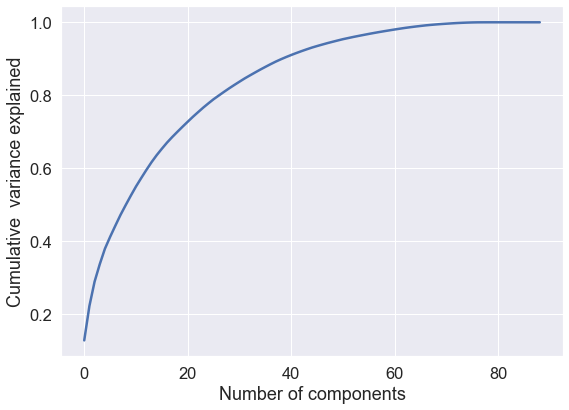

In [101]:
pca = perform_pca_plot_scree_plot(df_train[predictor])

**Analysis:**

Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose 60 components for our modeling

In [102]:
col = list(df_train[predictor].columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC1,PC2,PC3,Feature
0,-0.02,0.23,0.13,arpu_8
1,-0.11,0.11,0.12,onnet_mou_8
2,-0.12,0.19,0.14,offnet_mou_8
3,-0.01,0.02,0.03,roam_ic_mou_8
4,-0.02,0.03,0.05,roam_og_mou_8
5,-0.04,0.15,-0.07,loc_og_t2t_mou_8
6,-0.05,0.21,-0.13,loc_og_t2m_mou_8
7,-0.00,0.11,-0.11,loc_og_t2f_mou_8
8,-0.01,0.02,0.05,loc_og_t2c_mou_8
9,-0.06,0.24,-0.14,loc_og_mou_8


### 3.2 Model Training ###

*Approach*
- We will first train a Logistical Regression Model, which will form our Baseline
- We will then try  to try a Kernel and Random Forest and try to improve on our baseline
- Kernel Model we will use PCA and optimise for Prediction 
- Random Forest Model we will optimise Forecasting and use it for find the important features

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, make_scorer
from sklearn.svm import SVC
import itertools

In [104]:
# This function plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [105]:
## For y_true and y_pred display the Classification Metrics and plot Confusion Matrix
def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*20+"Classification Report"+'*'*20)
        print(classification_report(y_test,y_test_pred))
        
        if plot:
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, y_test_pred)
            print('*'*20+'Confusion Matrix'+'*'*20)
            # Plot non-normalized confusion matrix
            class_names = [0,1]
            plt.figure(figsize=(7,5))
            plot_confusion_matrix(cnf_matrix
                      , classes=class_names)                      
            plt.show()
      
        

In [106]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    y_test_pred = alg.predict(X_test_data)
      
    computeClassificationMetrics(y_test, y_test_pred, plot)
    

In [107]:
## For CV reusults plot the  C Value vs Accuracy Results        
def display_svm_stats(cv_results,param_value):
    gamma = cv_results[cv_results['param_gamma']==param_value]
    plt.plot(gamma["param_C"], gamma["mean_test_score"])
    plt.plot(gamma["param_C"], gamma["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma="+str(param_value))
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
    plt.xscale('log') 


#### Balancing by over-sampling minority class using SMOTE ####

We will start by balancing the data set using SMOTE technique. First we will balance the data set by SMOTE and then apply logistic regression model on the balanced data set.
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

- SMOTE technique should be applied only on the training data, after splitting the data set into training set and validation set. 
- If we apply SMOTE before splitting the data, we would leak the information in validation set into the training set. 





In [108]:
#Imbalance before SMOTE
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data : ", y_train_imb)
print("Imbalance in Test Data : ", y_test_imb)

X_train Shape :  (20967, 89)
X_test Shape :  (8986, 89)
Imbalance in Train Data :  0.0884032392026578
Imbalance in Test Data :  0.08842054263565892


In [109]:
print("Shape of train dataset before SMOTE ", df_train[predictor].shape)
x_tr,y_tr = sampling.fit_sample(df_train[predictor],df_train[response])
print("Shape of train dataset after SMOTE : ", x_tr.shape)

# Applying PCA : Principal Component Analysis using 60 components
pca = IncrementalPCA(n_components=60)    
X_train_pca = pca.fit_transform(x_tr)
X_test_pca = pca.transform(df_test[predictor])
print("Shape of train dataset after PCA : ", X_train_pca.shape)

Shape of train dataset before SMOTE  (20967, 89)
Shape of train dataset after SMOTE :  (38528, 89)
Shape of train dataset after PCA :  (38528, 60)


In [110]:
print("X_tr Shape", x_tr.shape)
print("y_tr Shape", y_tr.shape)

imb = (y_tr != 0).sum()/(y_tr == 0).sum()
print("Imbalance in Train Data : ",imb)

X_tr Shape (38528, 89)
y_tr Shape (38528,)
Imbalance in Train Data :  1.0



### Logistic Regression 


We will training a logistic regression and test it on a validation set. 


#### Baseline Logistic Regression Model

In [111]:
# Basic Logistric Regression
logreg1 = LogisticRegression(random_state = 0)


********************Classification Report********************
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8256
           1       0.30      0.81      0.44       730

    accuracy                           0.83      8986
   macro avg       0.64      0.82      0.67      8986
weighted avg       0.92      0.83      0.86      8986

********************Confusion Matrix********************


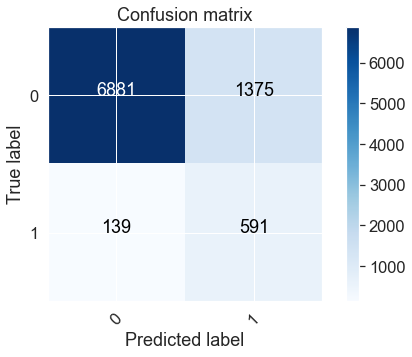

In [112]:
# Call model fit and evalute the validation set
model_fit(logreg1,X_train_pca, y_tr, X_test_pca, df_test[response] ,True)

We acheived a Accuracy of 83% an F1 Score of 0.86. This is a very decent prediction power on a unbalanced data set using Logistic Regression. 

#### Model Iteration 1: Using SVM with Appropriate Kernel for Predictive Model ####

- Choose the right kernel 

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8256
           1       0.38      0.75      0.50       730

    accuracy                           0.88      8986
   macro avg       0.68      0.82      0.72      8986
weighted avg       0.93      0.88      0.90      8986

********************Confusion Matrix********************


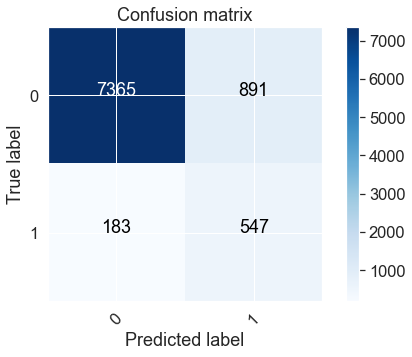

In [113]:
#rbf Kernel

lr = LogisticRegression(random_state=0)
lr.svm = SVC(kernel='rbf') 

# Call model fit and evalute the validation set
model_fit(lr.svm ,x_tr, y_tr, df_test[predictor],df_test[response] ,True)



********************Classification Report********************
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8256
           1       0.41      0.72      0.52       730

    accuracy                           0.89      8986
   macro avg       0.69      0.81      0.73      8986
weighted avg       0.93      0.89      0.91      8986

********************Confusion Matrix********************


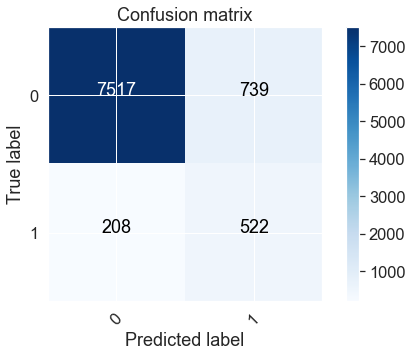

In [114]:
# Poly Kernel
lr = LogisticRegression(random_state=0)

lr.svm = SVC(kernel='poly') 
model_fit(lr.svm ,x_tr, y_tr, df_test[predictor],df_test[response] ,True)


********************Classification Report********************
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      8256
           1       0.33      0.80      0.47       730

    accuracy                           0.85      8986
   macro avg       0.65      0.83      0.69      8986
weighted avg       0.93      0.85      0.88      8986

********************Confusion Matrix********************


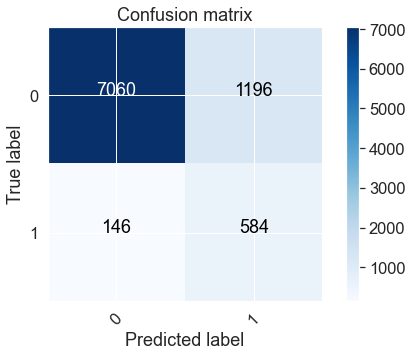

In [115]:
#Linear Kernel
lr = LogisticRegression(random_state=0)

lr.svm = SVC(kernel='linear') 
model_fit(lr.svm ,x_tr, y_tr, df_test[predictor],df_test[response] ,True)


**Analysis** : 
Since the Test set is unbalanced we need to look at the weighted score, for precision and Recall. 
Looks like the **Poly** Kernel is giving the 89% accuracy score with an F1 value of 0.91. This is really good. 
This also is in line with our understanding from EDA. 

First we will try to combine this with PCA and see if we can capture the variance in lower dimensions

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8256
           1       0.35      0.76      0.48       730

    accuracy                           0.87      8986
   macro avg       0.66      0.82      0.70      8986
weighted avg       0.93      0.87      0.89      8986

********************Confusion Matrix********************


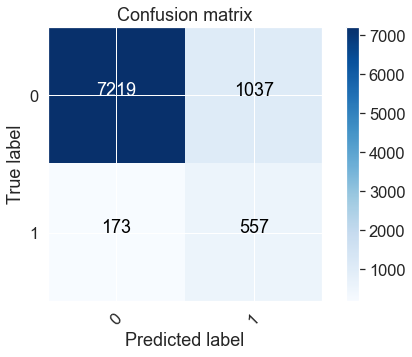

In [116]:
# Applying PCA to Kernel

lr = LogisticRegression(random_state=0)

lr.svm = SVC(kernel='poly') 
model_fit(lr.svm,X_train_pca, y_tr, X_test_pca, df_test[response] ,True)


**Analysis** : Its very clear that PCA degrades the SVM Score. 
- The reason could be that PCA projects the values in the linear space and that is causing some information to be lost, in such a way that the SVM Kernel cannot read it.
- https://www.researchgate.net/post/Is_there_a_specific_reason_that_using_PCA_gives_worse_results_than_without_using_it_in_SVM_classification
- We will NOT be using PCA for SVM. 
- Lets next try to optimise the C and gamma hyperparameters for the SVM and see if we can improve the results

In [117]:
# # commenting as grid search is taking a long time on local workstation
# # creating a KFold object with 5 splits 
# folds = KFold(n_splits = 3, shuffle = True, random_state = 101)

# # Set the parameters by cross-validation
# hyper_params = [ {'gamma': [1e-1,1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
# #hyper_params = [ {'gamma': [1e-1], 'C': [1]}]

# # specify model
# model = SVC(kernel="poly")

# # set up GridSearchCV()
# model_cv_svm = RandomizedSearchCV(estimator = model, 
#                         param_distributions = hyper_params, 
#                         scoring= 'accuracy', 
#                         cv = folds,
#                         n_jobs = -1,
#                         verbose = 2,
#                         return_train_score=True, random_state=100)      

# # fit the model
# model_cv_svm.fit(X_tr, y_tr)  


# ## This will take some time, and you should twiddle your thumbs

In [118]:
# Commenting as grid search is taking a long time
# # cv results
# svm_cv_results = pd.DataFrame(model_cv_svm.cv_results_)
# svm_cv_results['param_C'] = svm_cv_results['param_C'].astype('int')
# gamma=[1e-1,1e-2, 1e-3, 1e-4]
# plt.figure(figsize=(16,5))
# plt.subplot(141)
# display_svm_stats(svm_cv_results,gamma[0])
# plt.subplot(142)
# display_svm_stats(svm_cv_results,gamma[1])
# plt.subplot(143)
# display_svm_stats(svm_cv_results,gamma[2])
# plt.subplot(144)
# display_svm_stats(svm_cv_results,gamma[3])
# plt.show()

**Analysis**

We wil be using the default values, as GridSearch is a brute force algorithm, and is taking long time to process on desktop workstation. 
Also with the poly kernel we are getting 89% Accuracy with Fscore of 0.91 which is better than our baseline

In [119]:
# # printing the optimal accuracy score and hyperparameters
# best_score = model_cv_svm.best_score_
# best_hyperparams = model_cv_svm.best_params_

# log("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,2), best_hyperparams))

**Analysis**

We wil be using the default values, as GridSearch is a brute force algorithm, and is taking long time to process on desktop workstation. 
Also with the poly kernel we are getting 89% Accurity with Fscore of 90 which is better than our baseline

In [120]:
#Store session so that heavy computation results can be persisted in memory
#import dill
#dill.dump_session('notebook_env.db')

 #### Model Iteration 2: Using RandomForest 

In [152]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier


In [153]:
rfc = RandomForestClassifier(random_state=0)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      8256
           1       0.50      0.55      0.52       730

    accuracy                           0.92      8986
   macro avg       0.73      0.75      0.74      8986
weighted avg       0.92      0.92      0.92      8986

********************Confusion Matrix********************


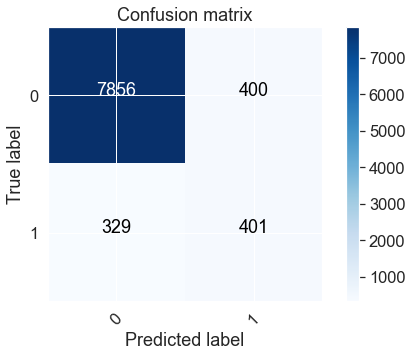

In [123]:
# Call model fit and evalute the validation set
model_fit(rfc,X_train_pca, y_tr, X_test_pca, df_test[response] ,True)

The baseline Random Forest regression model gave a Recall of 92% and Precision of 92% on the validation set.

### Hyperparameter Tuning using GridSearchCV



In [124]:
def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier(random_state=0)
    else :
        rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

**Tuning max_depth**

Let's try to find the optimum values for max_depth and understand how the value of max_depth impacts the overall accuracy of the ensemble.

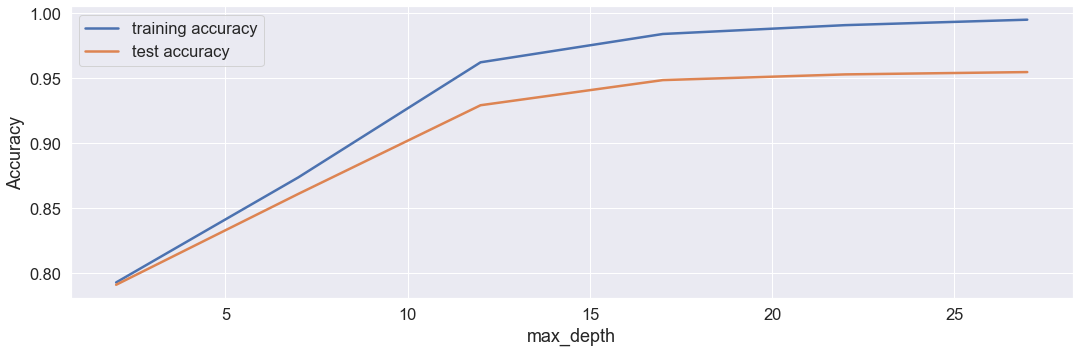

In [125]:
# parameters to build the model on
parameters = {'max_depth': range(2, 30, 5)}
tune_hyperparameter(parameters,X_train_pca, y_tr)

**Analysis:**

We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomes stagnant.
12 and 18 value have peek convergence and can be used for grid veiw search.

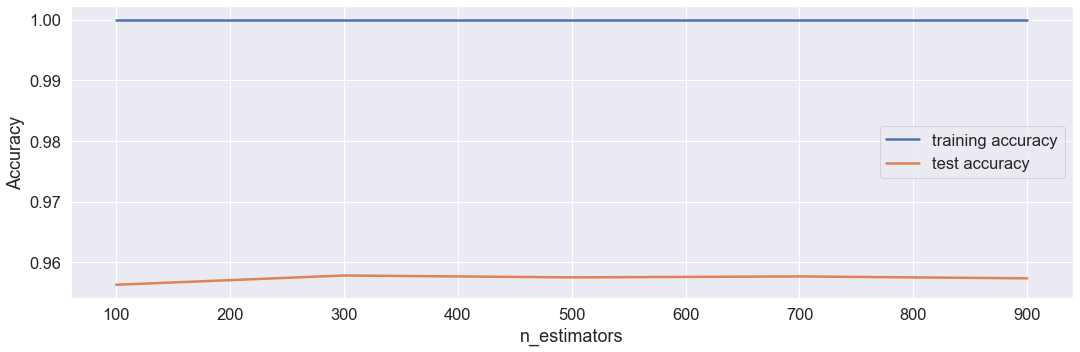

In [126]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 200)}
tune_hyperparameter(parameters,X_train_pca, y_tr)

**Analysis:** 
Score almost remain the same with very low dip throught the range. We can use 200 for grid view search.

**Tuning max_features**

Let's find how the model performance varies with max_features, which is the maximum number of features considered for splitting at a node.

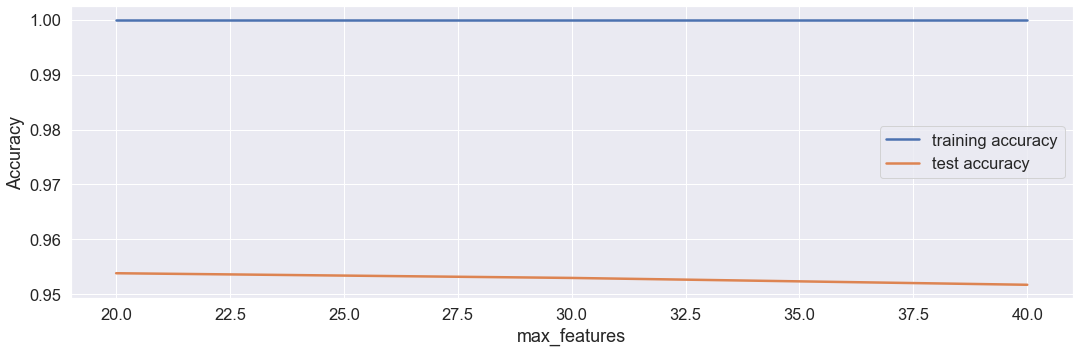

In [127]:
# parameters to build the model on
parameters = {'max_features': [20,30,40]}
tune_hyperparameter(parameters,X_train_pca, y_tr,4)

**Analysis**

Apparently, accuracy of training seems to be stable and test scores seems to decrease after 30 

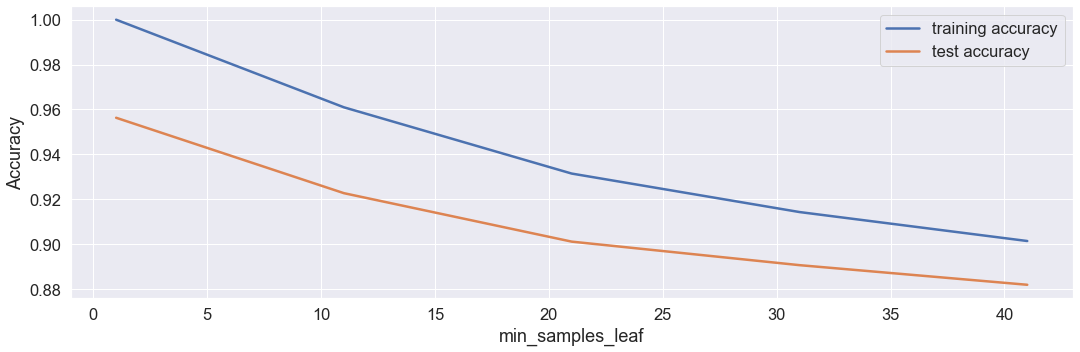

In [128]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 50, 10)}
tune_hyperparameter(parameters,X_train_pca, y_tr)

**Analysis:** 

10 to 20 seems to be a good range and that will be used in grid search.

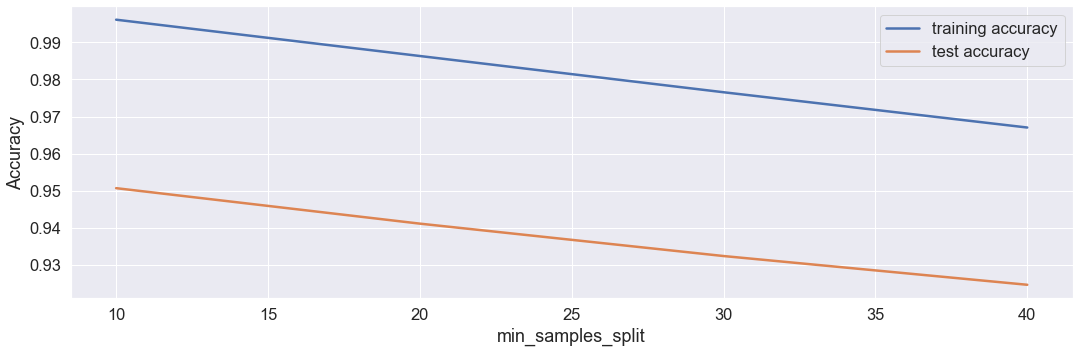

In [129]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 50, 10)}
tune_hyperparameter(parameters,X_train_pca, y_tr)

**Analysis:** 

Range 10 to 20 is optimal with good accuracy.

In [148]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [12,17],
    'n_estimators': [300],
    'max_features': [25],
    'min_samples_leaf': [5,10],
    'min_samples_split': [10,15]
}

rf = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = params, 
                          cv = 5, n_jobs = -1,verbose = 1, scoring= "accuracy", 
                          return_train_score=True)

In [149]:
rf_grid_search.fit(X_train_pca, y_tr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 31.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [12, 17], 'max_features': [25],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 15], 'n_estimators': [300]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [150]:
print("We can get accuracy of {} using \n{}".format(round(rf_grid_search.best_score_,2),rf_grid_search.best_params_))

We can get accuracy of 0.94 using 
{'max_depth': 17, 'max_features': 25, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}


Building and Evaluating the Final Model for Random Forest


********************Classification Report********************
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8256
           1       0.45      0.64      0.53       730

    accuracy                           0.91      8986
   macro avg       0.71      0.79      0.74      8986
weighted avg       0.92      0.91      0.91      8986

********************Confusion Matrix********************


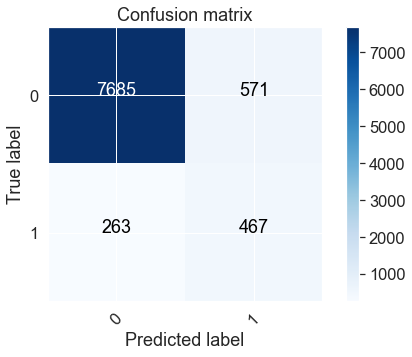

In [151]:
rfc = RandomForestClassifier(max_depth=17,
                             max_features=25,
                             min_samples_leaf=5,
                             min_samples_split=10,
                             n_estimators=300,
                             n_jobs = -1,random_state=0)
#Call model fit with validate set

model_fit(rfc,X_train_pca, y_tr, X_test_pca, df_test[response] ,True)

#### Model Iteration 3: Using XGB for Forecasting Model with Feature Importance ####

In [134]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

[00:19:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
********************Classification Report********************
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8256
           1       0.63      0.60      0.61       730

    accuracy                           0.94      8986
   macro avg       0.80      0.78      0.79      8986
weighted avg       0.94      0.94      0.94      8986

********************Confusion Matrix********************


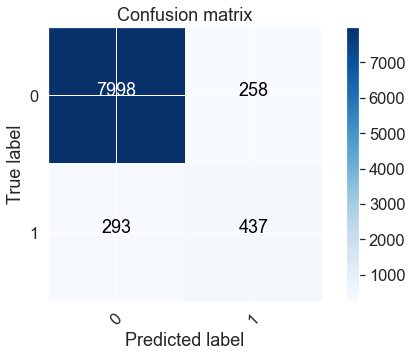

In [135]:
# fit model on training data with default hyperparameters
model = XGBClassifier(random_state=0)
model_fit(model,x_tr,y_tr, df_test[predictor],df_test[response] ,True)

In [136]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# specify model
xgb_model = XGBClassifier(random_state=0)

#auc scorer
scorer = make_scorer(roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= "accuracy", # auc score
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)      

In [137]:
# fit the model
model_cv.fit(x_tr,y_tr)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.3min finished


[00:25:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [138]:
# cv results
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

In [139]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy score of **'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

We can get accuracy score of **0.96** using {'learning_rate': 0.2, 'subsample': 0.5}


In [140]:
def plot_for_xboost(param_grid,cv_results):
    plt.figure(figsize=(18,5))
    for n, subsample in enumerate(param_grid['subsample']):
        # subplot 1/n
        plt.subplot(1,len(param_grid['subsample']), n+1)
        df = cv_results[cv_results['param_subsample']==subsample]

        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('Accuracy')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='lower right')
        plt.xscale('log')

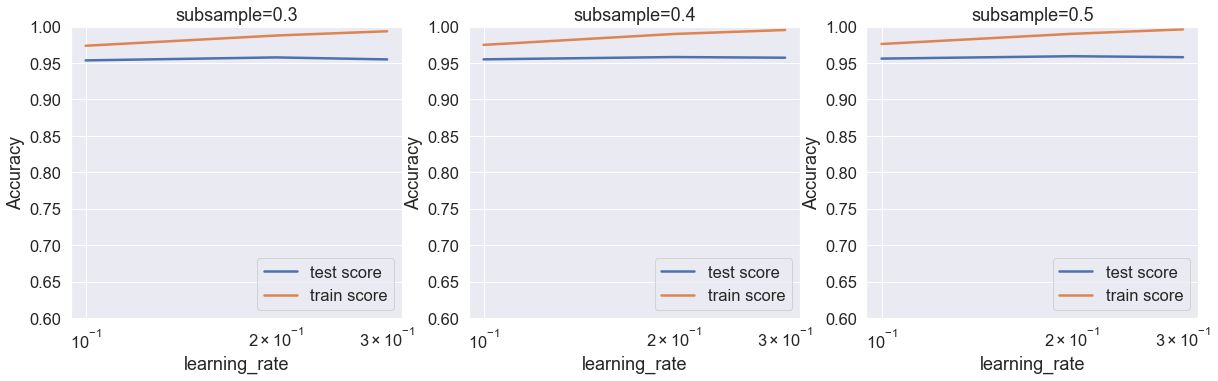

In [141]:
param_grid1 = {'learning_rate': [0.1,0.2,0.3], 'subsample': [0.3,0.4,0.5]}  
plot_for_xboost(param_grid1,cv_results_xboost)

#### Building and Evaluating the Final Model ####

[00:26:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
********************Classification Report********************
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8256
           1       0.61      0.62      0.62       730

    accuracy                           0.94      8986
   macro avg       0.79      0.79      0.79      8986
weighted avg       0.94      0.94      0.94      8986

********************Confusion Matrix********************


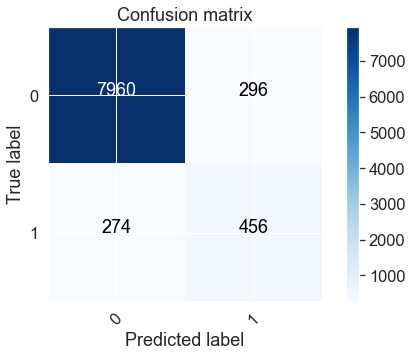

In [142]:
#chosen hyperparameters
# fit model on training data

model = XGBClassifier(learning_rate = 0.2, subsample = 0.5, random_state=0)
model_fit(model,x_tr,y_tr, df_test[predictor],df_test[response] ,True)


#### Feature Importance ####

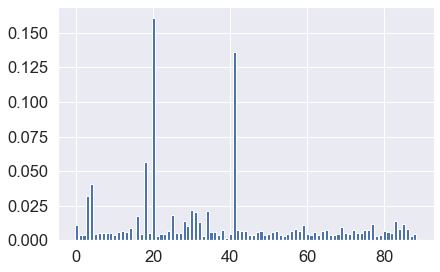

In [143]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

**Observation** - Some features are more important than the others. So definetely  they can contribute towards forecasting

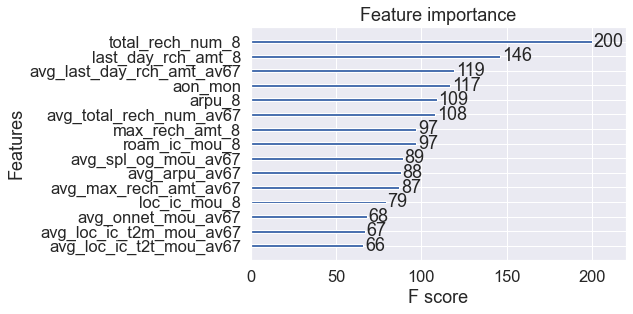

In [144]:
# plot feature importance

col = list(X_train.columns)
model.get_booster().feature_names = col

ax =plot_importance(model.get_booster(),max_num_features=15)
figure = ax.figure
figure.set_size_inches=(30,45)

**Analysis**

The most important feature is **The total num of times recharge is done for the 8th Month**. This is by far the most important feature

The other important features are **Last day recharge Amt** for the 8th month, **Total Recharge Data** for 8th month, **Max Recharge Amt** for the 8th month 

So in summary, the Recharge value and Frequency of the 8th Month is a significant indicator of churn. This is logical and makes sense.

## Step 4 : Model Training Summary ##

#### Training Summary ####

#### Business Recommendations ####